## **Retrieve category codings for users and items**

In [5]:
import pickle
with open("/content/drive/My Drive/1m_ratings.csv", 'rb') as rating_1m:
  ratings = pickle.load(rating_1m)

In [6]:
# Generate all_users and all_items, i.e. number of users and items 
import numpy as np
ratings['user_id'] = ratings['userId'].astype("category").cat.codes
df_sort = ratings.sort_values(by=['userId', 'timestamp']).reset_index(drop=True)
all_users = list(np.sort(df_sort.userId.unique()))
all_items = list(np.sort(df_sort.movieId.unique()))
print("Number of users: ", len(all_users))
print("Number of movies: ", len(all_items))

Number of users:  6040
Number of movies:  3706


In [7]:
def train_test_split(df,n):
    """
    Splits our original data into one test and one
    training set. 
    The test set is made up of one item for each user. This is
    our holdout item used to compute Top@K later.
    The training set is the same as our original data but
    without any of the holdout items.
    Args:
        df (dataframe): Our original data
    Returns:
        df_train (dataframe): All of our data except holdout items
        df_test (dataframe): Only our holdout items.
    """

    # Create two copies of our dataframe that we can modify
    df_test = df.copy(deep=True)
    df_train = df.copy(deep=True)

    # Group by user_id and select only the last n item
    # Test dataframe
    df_test = df_test.groupby(['user_id']).tail(n)
    df_test = df_test[['userId', 'user_id', 'movieId', 'rating']]

    # Remove the test set from the test set
    mask_test = df_test.index
    df_train = df_train.drop(mask_test)
    df_train = df_train[['userId', 'user_id', 'movieId', 'rating']]

    return df_train, df_test

k = 5
df_train, df_test = train_test_split(df_sort,k)

Only items in the df_train are category coded, not the entire dataset, as the model is only trained on df_train dataset

In [8]:
# 110 items with cold start problem

df_train['item_id'] = df_train['movieId'].astype("category").cat.codes
df_train

item_list = df_train[['movieId', 'item_id']]
print(len(item_list))
item_list = item_list.drop_duplicates()
print(len(item_list))
item_list.head(2)

970009
3703


movieId  item_id
0     3186     2967
1     1270     1177

## **Download movies' additional information**

In [9]:
#movies = pd.read_csv("/content/drive/My Drive/movies.dat")
import pandas as pd
rnames = ['movie_id','title','genres']

movies = pd.read_table('/content/drive/My Drive/movies.dat',sep='::',header=None, names=rnames)
movies.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


movie_id             title                        genres
0         1  Toy Story (1995)   Animation|Children's|Comedy
1         2    Jumanji (1995)  Adventure|Children's|Fantasy

## **Grouping of movie's information**

In [12]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies['genre'] = movies.genres.str.split('|')
movies.head()

movie_id  ...                             genre
0         1  ...   [Animation, Children's, Comedy]
1         2  ...  [Adventure, Children's, Fantasy]
2         3  ...                 [Comedy, Romance]
3         4  ...                   [Comedy, Drama]
4         5  ...                          [Comedy]

[5 rows x 5 columns]

In [17]:
# Find out how many categories is each movie grouped under
genre_count = [len(i) for i in movies.genre]
genre_count_df = pd.DataFrame(genre_count, columns = ['genre_count'])
movies1 = pd.concat([movies, genre_count_df], axis = 1)
movies1['categories_movie_isin'] = movies1['genre_count'].astype(str) + "_genre_category"
movies_info = pd.merge(movies, movies1, left_on = 'movie_id', right_on = 'movie_id', how = 'left')
movies_info = pd.merge(item_list, movies1, left_on = 'movieId', right_on = 'movie_id', how = 'left')
movies_info.year = movies_info.year.astype(str)
movies_info = movies_info.drop(columns=['movie_id','genre'])
movies_info.head(3)

movieId  item_id  ... genre_count categories_movie_isin
0     3186     2967  ...           1      1_genre_category
1     1270     1177  ...           2      2_genre_category
2     1721     1573  ...           2      2_genre_category

[3 rows x 7 columns]

## **Read trained embeddings**

In [18]:
import pickle
with open("/content/drive/My Drive/gmf_item_embedding_neg.pickle", 'rb') as gmf_item:
  trained_gmf_items = pickle.load(gmf_item)
with open("/content/drive/My Drive/mlp_item_embeddings_neg.pickle", 'rb') as mlp_item:
  trained_mlp_items = pickle.load(mlp_item)


In [19]:
# Create combine data set
# Using mlp items - implicit feedback
dataset = pd.DataFrame(trained_mlp_items)
dataset['item_id'] = dataset.index
dataset = pd.merge(dataset, movies_info, left_on = 'item_id', right_on = 'item_id').dropna()
dataset['Label'] = pd.factorize(dataset['genres'])[0] # Create LabelEncoder
label_code_dict = dict(zip(dataset['Label'], dataset['genres'])) # Create dict to map LabelEncoder
print(len(dataset))
dataset.head()


3703


0         1         2  ...  genre_count  categories_movie_isin  Label
0 -0.745756 -0.810328 -0.180637  ...            3       3_genre_category      0
1 -0.375606 -0.429183 -0.441106  ...            3       3_genre_category      1
2 -0.227230 -0.456836  0.157980  ...            2       2_genre_category      2
3 -0.398684 -0.282128  0.012208  ...            2       2_genre_category      3
4  0.060892 -0.138244 -0.118853  ...            1       1_genre_category      4

[5 rows x 72 columns]

In [ ]:
# Create combine data set
# Using gmf items - implicit feedback
dataset = pd.DataFrame(trained_gmf_items)
dataset['item_id'] = dataset.index
dataset = pd.merge(dataset, movies_info, left_on = 'item_id', right_on = 'item_id').dropna()
dataset['Label'] = pd.factorize(dataset['genres'])[0] # Create LabelEncoder
label_code_dict = dict(zip(dataset['Label'], dataset['genres'])) # Create dict to map LabelEncoder
dataset.head()

0         1  ...                             year_genre  Label
0 -0.501720 -0.117356  ...   < 1995 - Animation|Children's|Comedy      0
1 -0.354279 -0.220053  ...  < 1995 - Adventure|Children's|Fantasy      1
2 -0.208623 -0.212250  ...                < 1995 - Comedy|Romance      2
3  0.119605 -0.011758  ...                  < 1995 - Comedy|Drama      3
4 -0.071274 -0.010225  ...                        < 1995 - Comedy      4

[5 rows x 74 columns]

In [ ]:
dataset.to_csv("michael_data.csv")

# K-Means silhouette analysis approach

## MLP silhoutte analysis

In [20]:
# Define target variables
X = dataset.iloc[:, np.r_[0:64]]
Y = dataset['Label']
print("input:\n", X)
print("Target:\n", Y)

input:
             0         1         2   ...        61        62        63
0    -0.745756 -0.810328 -0.180637  ... -0.113671  0.664693 -0.306955
1    -0.375606 -0.429183 -0.441106  ... -0.390956  0.233110 -0.741150
2    -0.227230 -0.456836  0.157980  ... -0.067575  0.419661 -0.313982
3    -0.398684 -0.282128  0.012208  ...  0.298142  0.493528  0.016806
4     0.060892 -0.138244 -0.118853  ...  0.263117  0.346135 -0.067497
...        ...       ...       ...  ...       ...       ...       ...
3698  0.694461  0.068542  0.612856  ...  0.123586 -0.029553  0.375214
3699  0.133477  0.202511  0.300273  ...  0.413007 -0.122140  0.524180
3700  0.593592  0.434417  0.365325  ...  0.747357  0.125996  0.633827
3701 -0.421032  0.010697  0.047818  ...  1.041316  0.397842  0.698279
3702  0.108351 -0.047785  0.500352  ...  0.370696  0.058396  0.260548

[3703 rows x 64 columns]
Target:
 0        0
1        1
2        2
3        3
4        4
        ..
3698     4
3699    12
3700    12
3701    12
3702   

In [21]:
print(len(X), len(Y)) # confirmed that there are 3703 movies and their embeddings

3703 3703


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.18301505
For n_clusters = 3 The average silhouette_score is : 0.13191415
For n_clusters = 4 The average silhouette_score is : 0.12959543
For n_clusters = 5 The average silhouette_score is : 0.122917846
For n_clusters = 6 The average silhouette_score is : 0.12442448
For n_clusters = 7 The average silhouette_score is : 0.1396362
For n_clusters = 8 The average silhouette_score is : 0.13865103
For n_clusters = 9 The average silhouette_score is : 0.14497189
For n_clusters = 10 The average silhouette_score is : 0.14419718
For n_clusters = 11 The average silhouette_score is : 0.13615169
For n_clusters = 12 The average silhouette_score is : 0.13740338
For n_clusters = 13 The average silhouette_score is : 0.13745889
For n_clusters = 14 The average silhouette_score is : 0.13286498
For n_clusters = 15 The average silhouette_score is : 0.13330963
For n_clusters = 16 The average s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For n_clusters = 250 The average silhouette_score is : 0.09658163


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For n_clusters = 300 The average silhouette_score is : 0.09431618


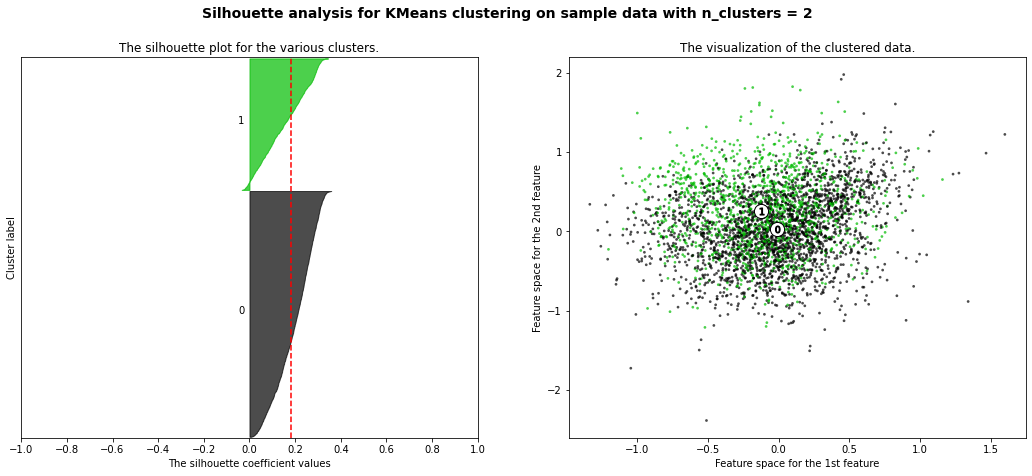

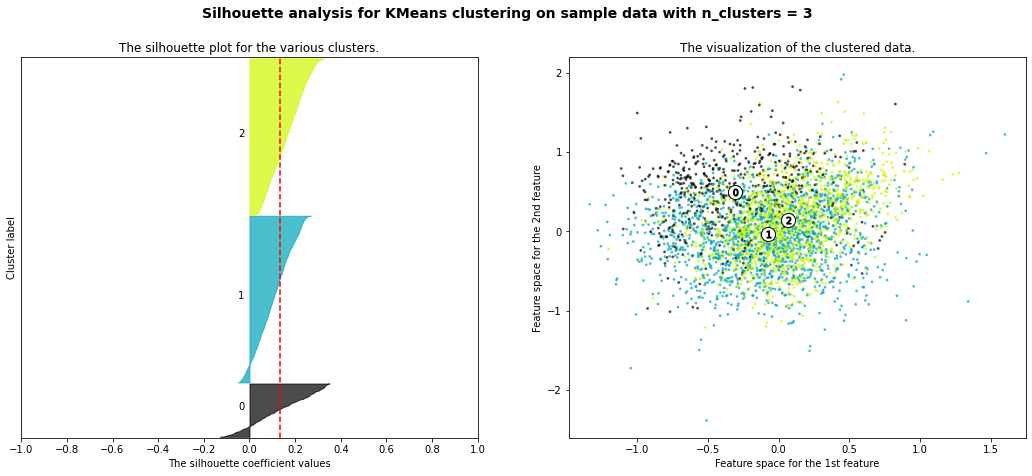

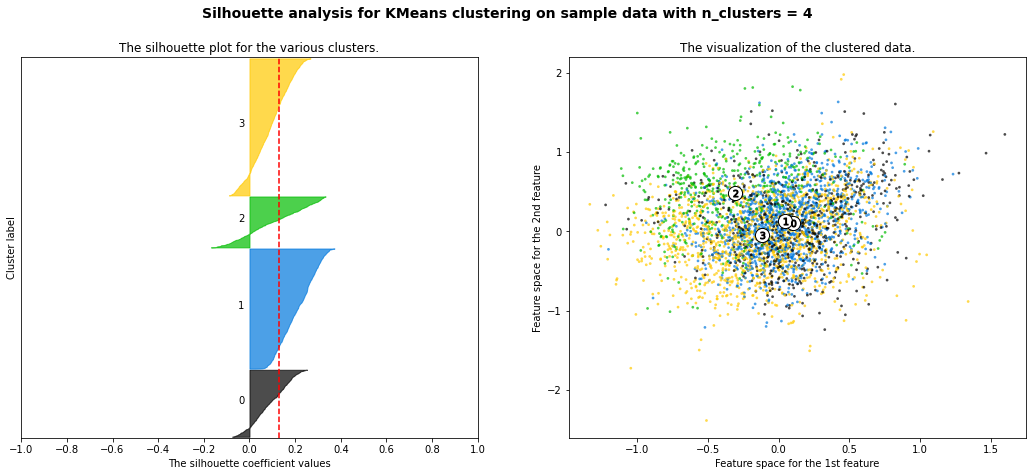

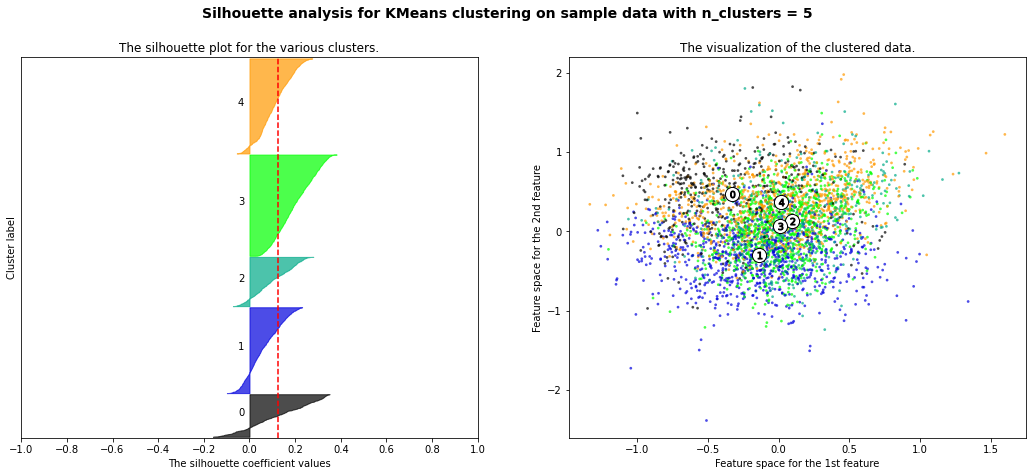

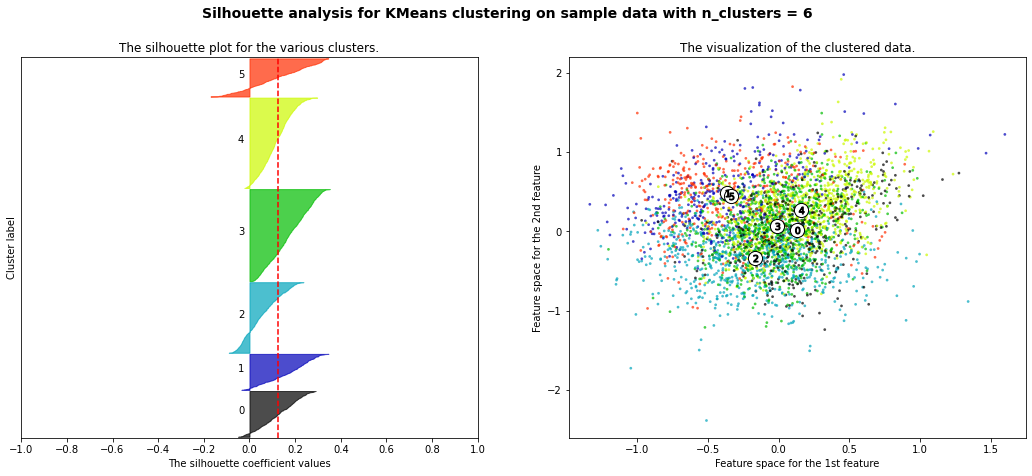

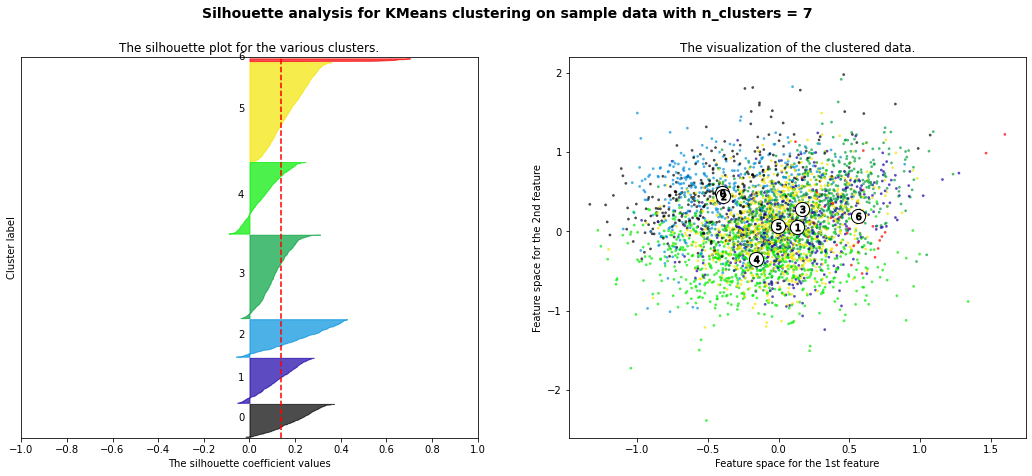

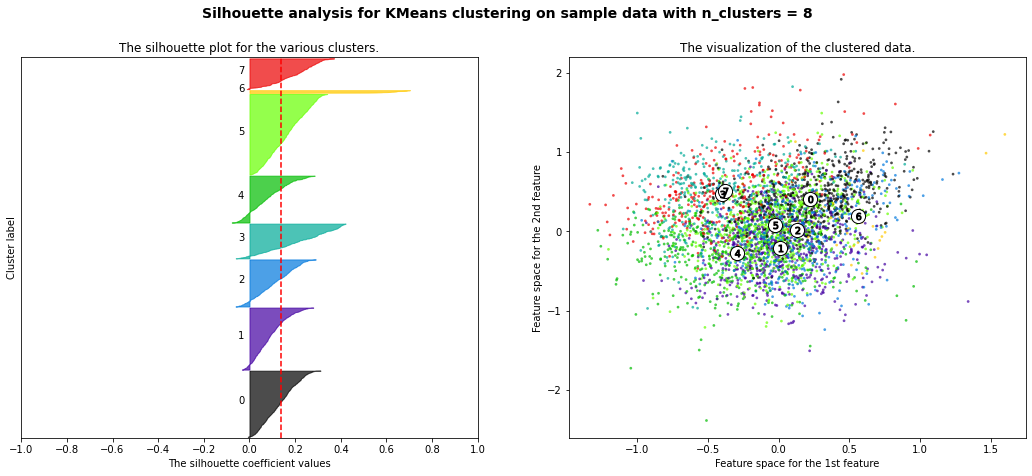

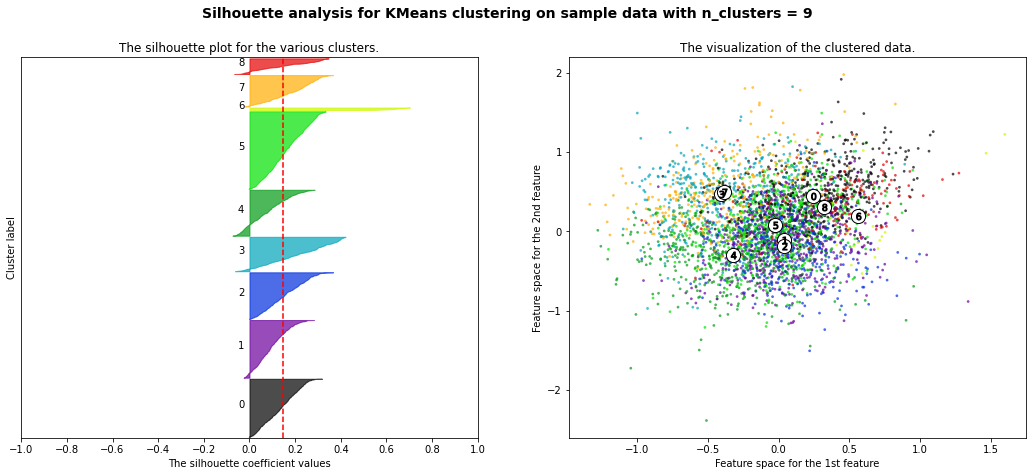

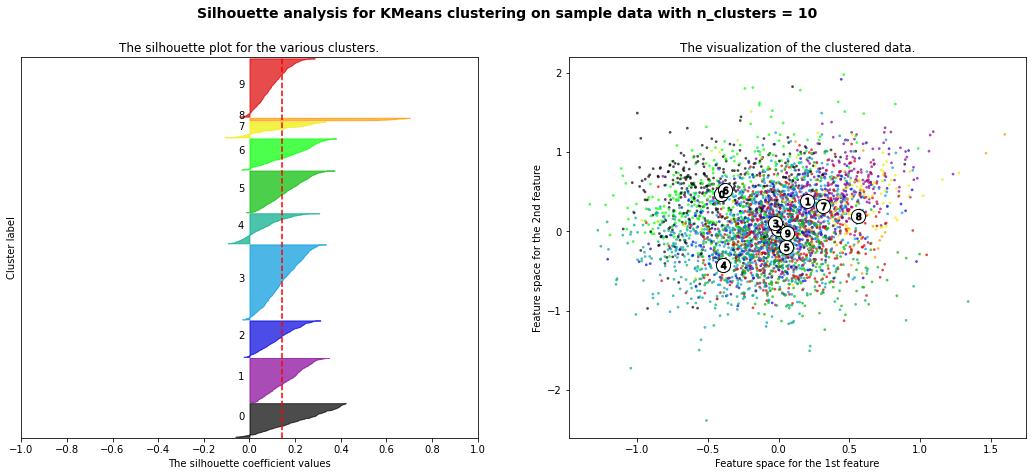

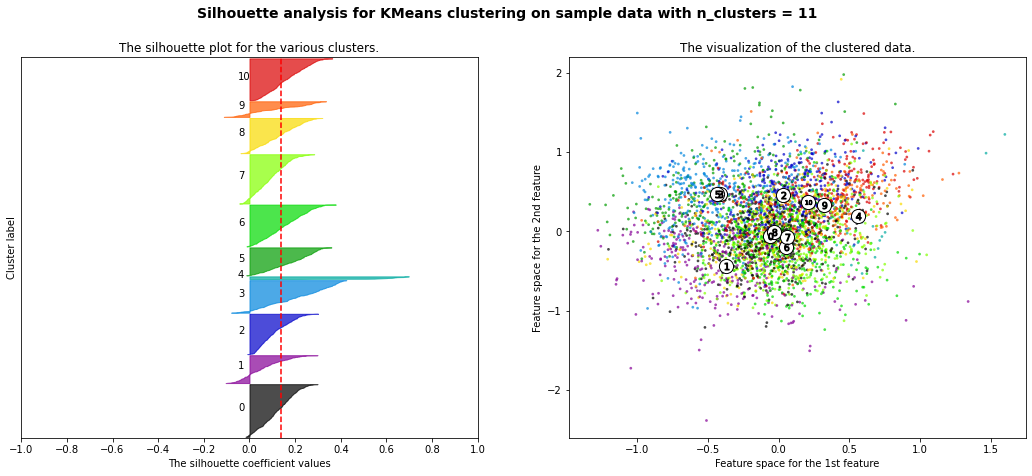

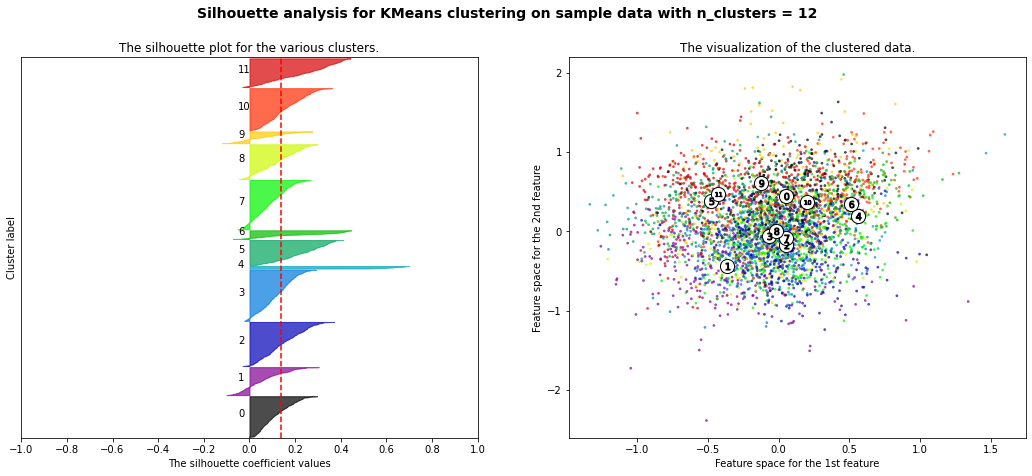

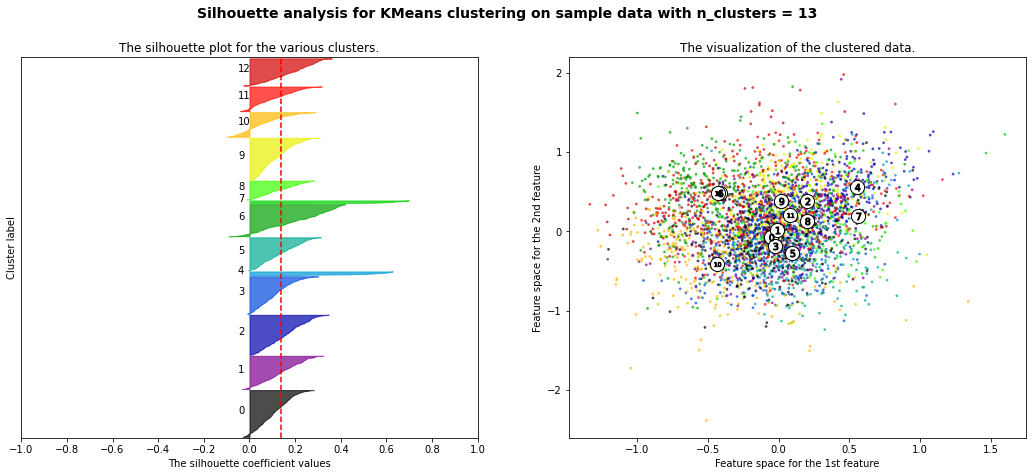

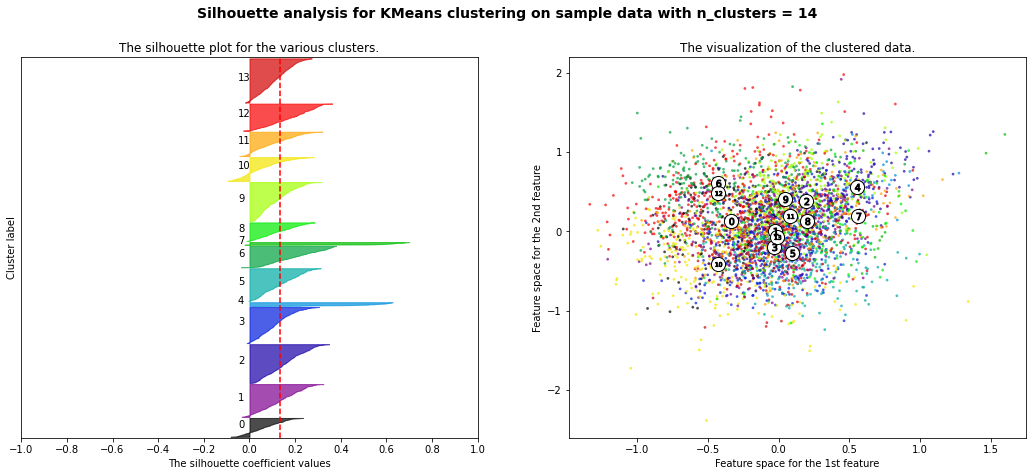

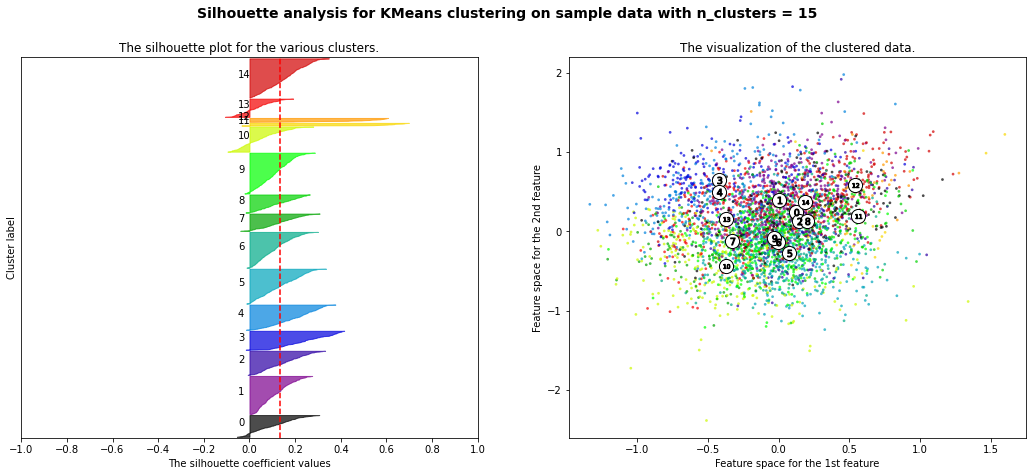

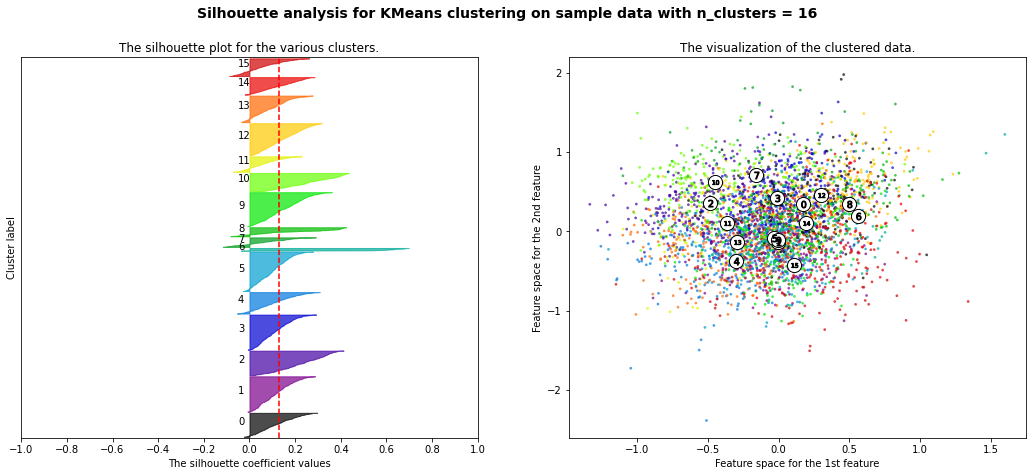

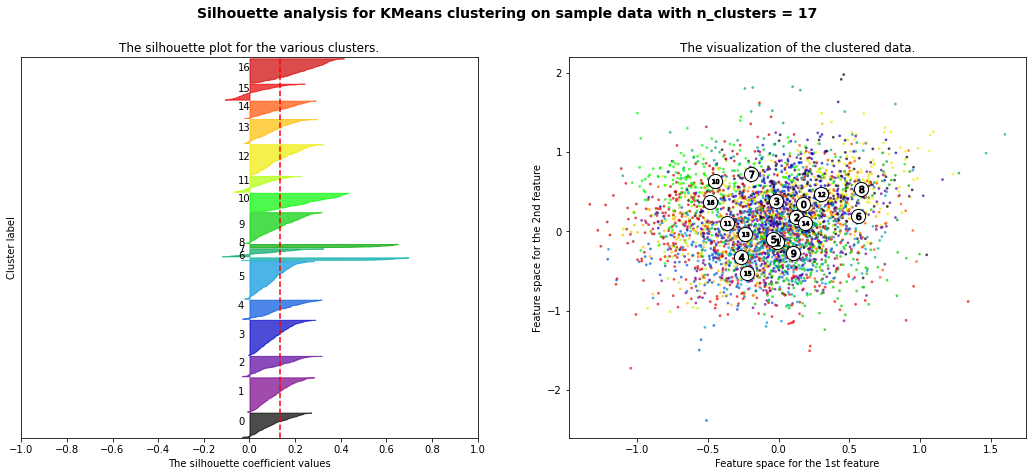

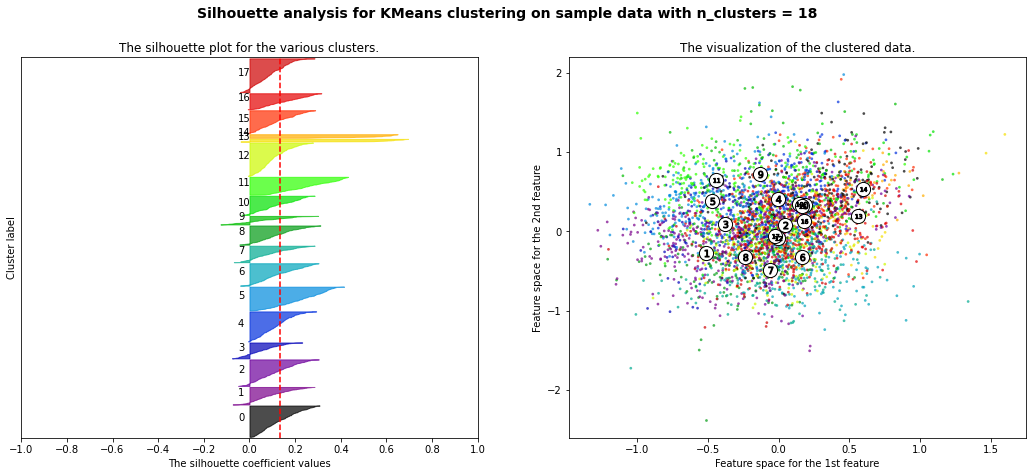

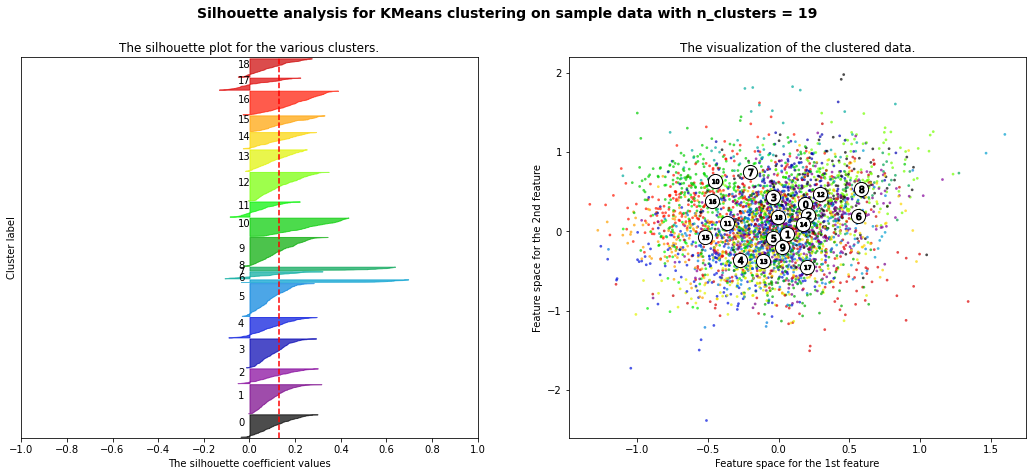

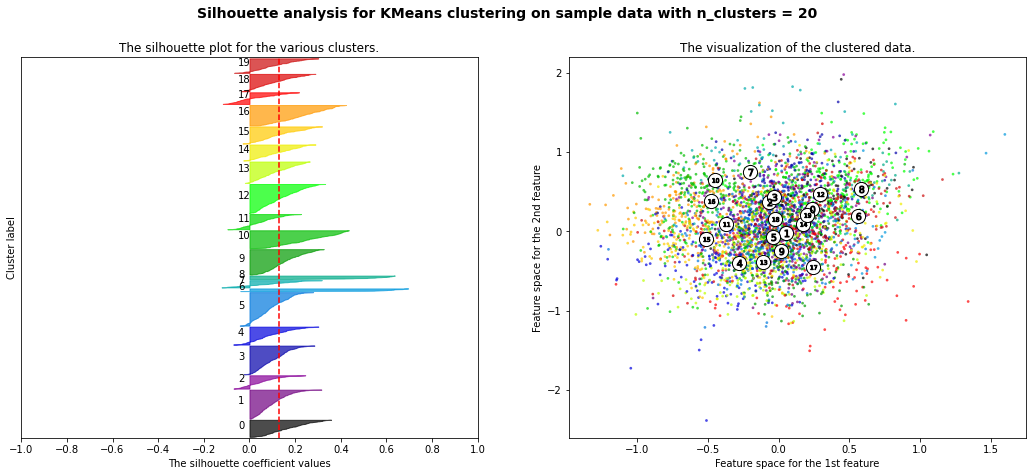

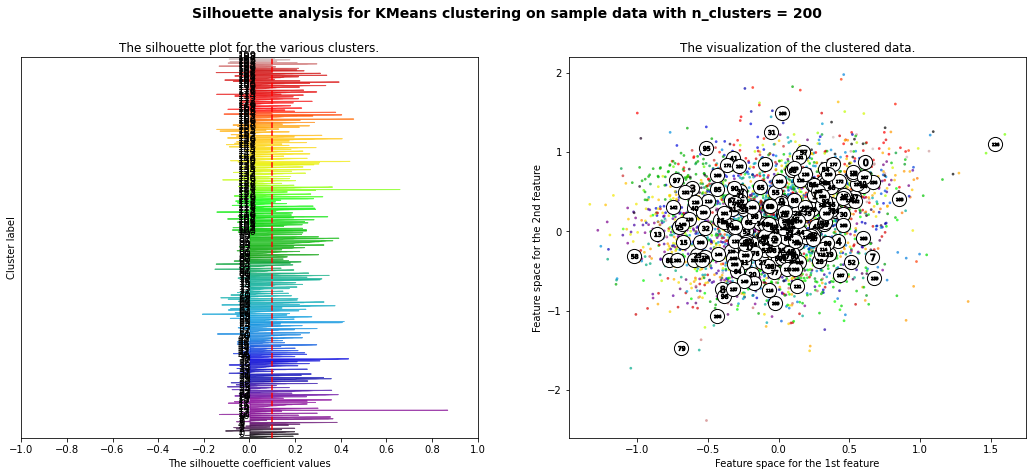

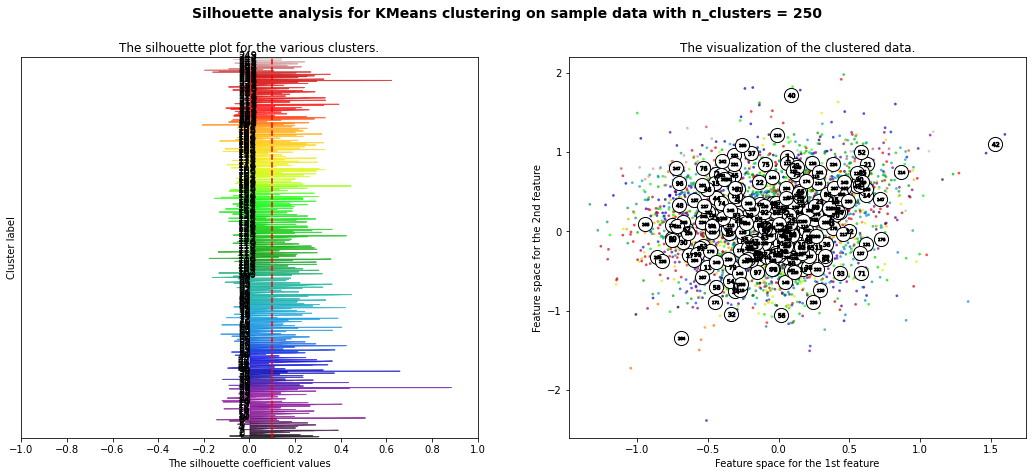

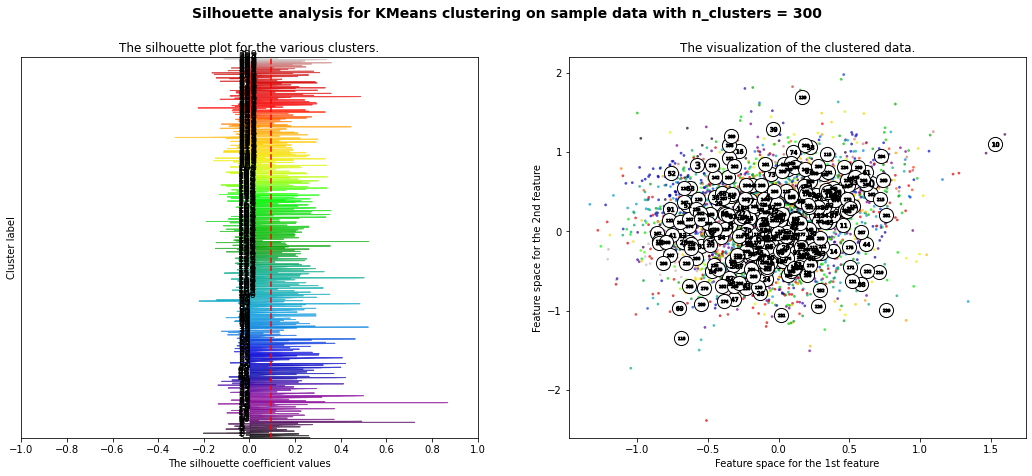

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = list(range(2, 21))
b = [200, 250, 300]
range_n_clusters.extend(b)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## GMF silhoutte analysis

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.10295879
For n_clusters = 3 The average silhouette_score is : 0.09005689
For n_clusters = 4 The average silhouette_score is : 0.06905319
For n_clusters = 5 The average silhouette_score is : 0.07286976
For n_clusters = 6 The average silhouette_score is : 0.06591723
For n_clusters = 7 The average silhouette_score is : 0.056661963
For n_clusters = 8 The average silhouette_score is : 0.04828057
For n_clusters = 9 The average silhouette_score is : 0.051452745
For n_clusters = 10 The average silhouette_score is : 0.042650864
For n_clusters = 11 The average silhouette_score is : 0.04767622
For n_clusters = 12 The average silhouette_score is : 0.042429127
For n_clusters = 13 The average silhouette_score is : 0.0420531
For n_clusters = 14 The average silhouette_score is : 0.03707838
For n_clusters = 15 The average silhouette_score is : 0.03910961
For n_clusters = 16 The averag

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For n_clusters = 250 The average silhouette_score is : -0.00891883


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For n_clusters = 300 The average silhouette_score is : -0.0048761596


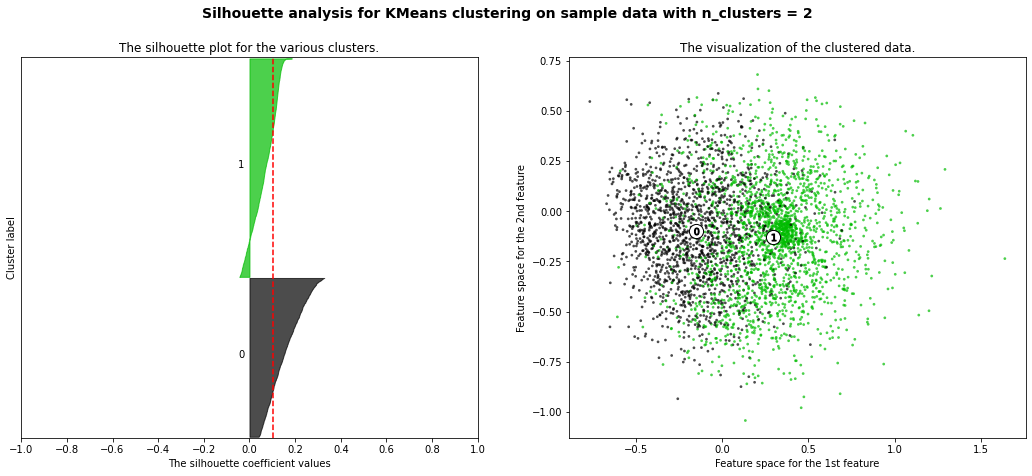

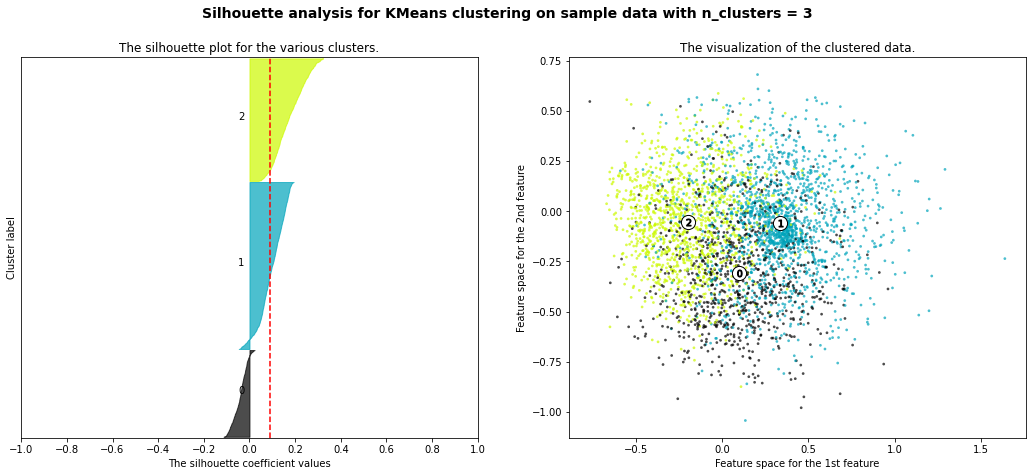

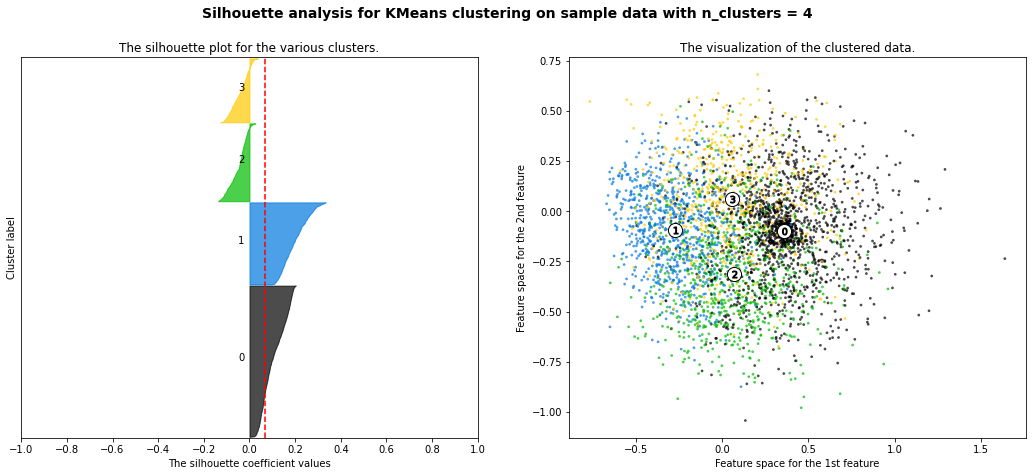

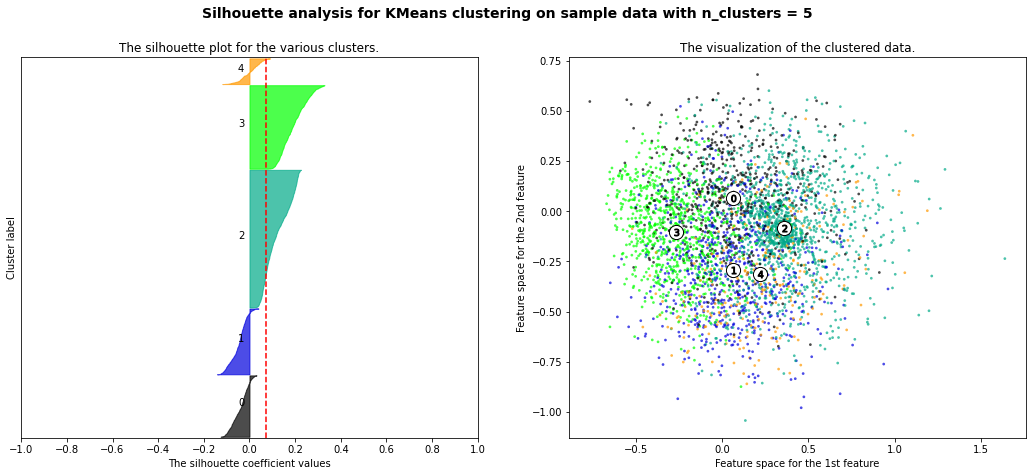

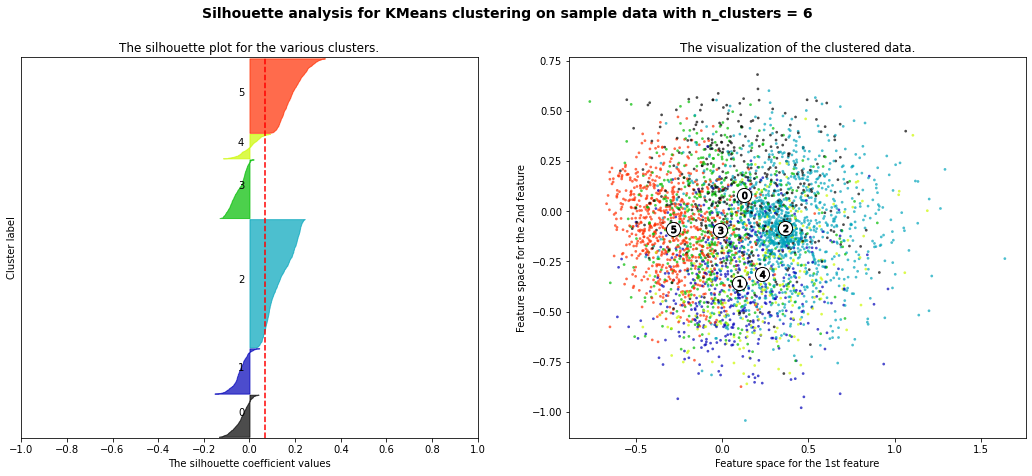

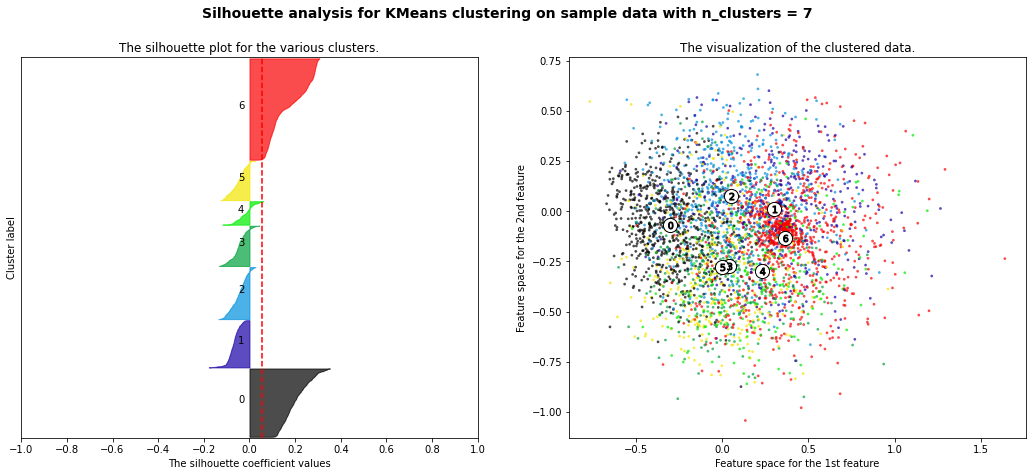

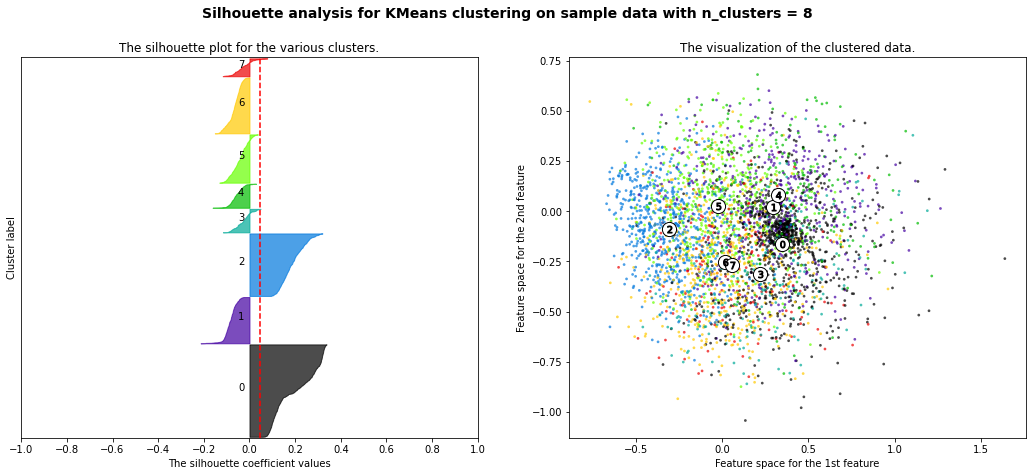

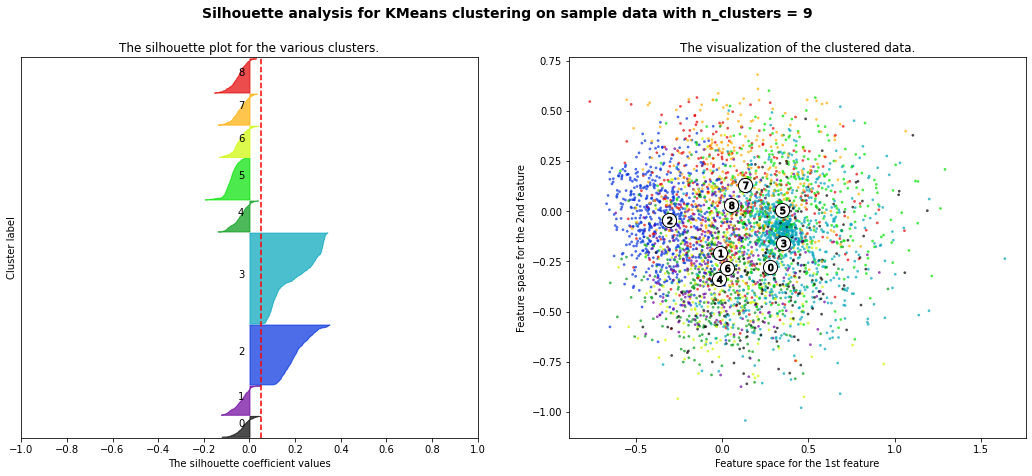

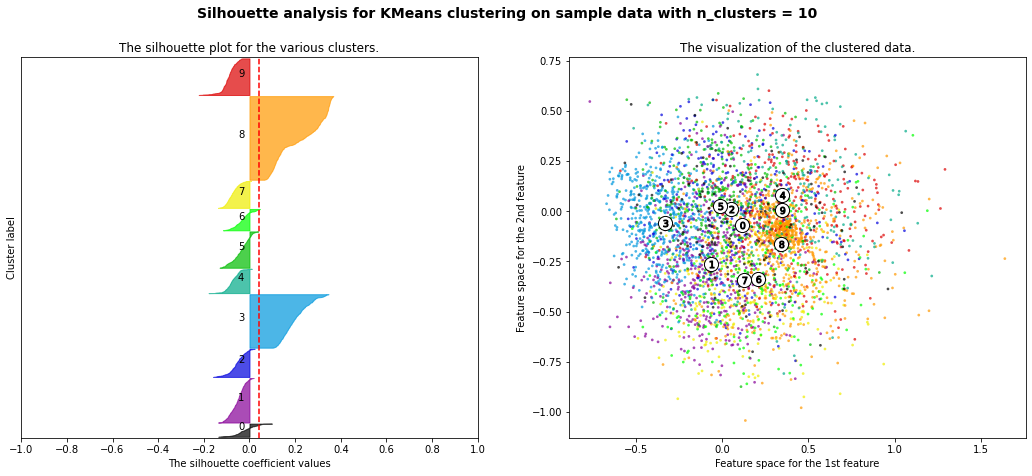

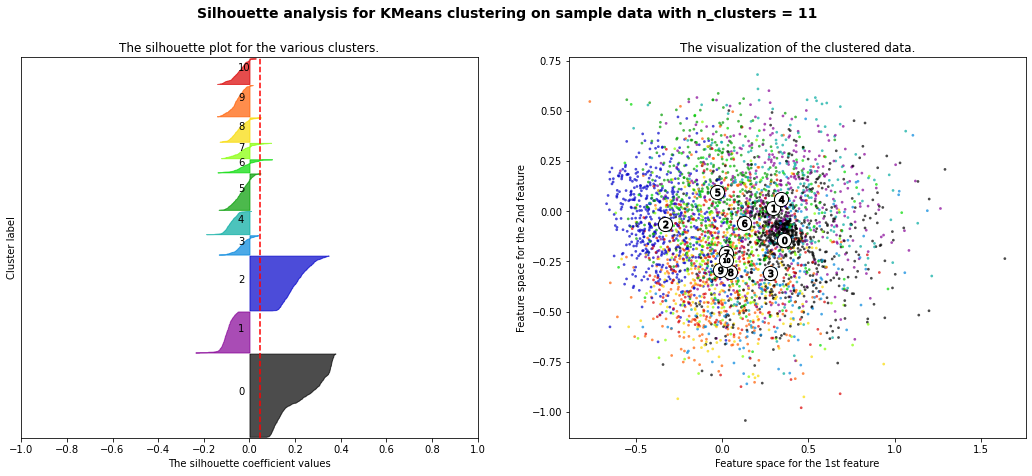

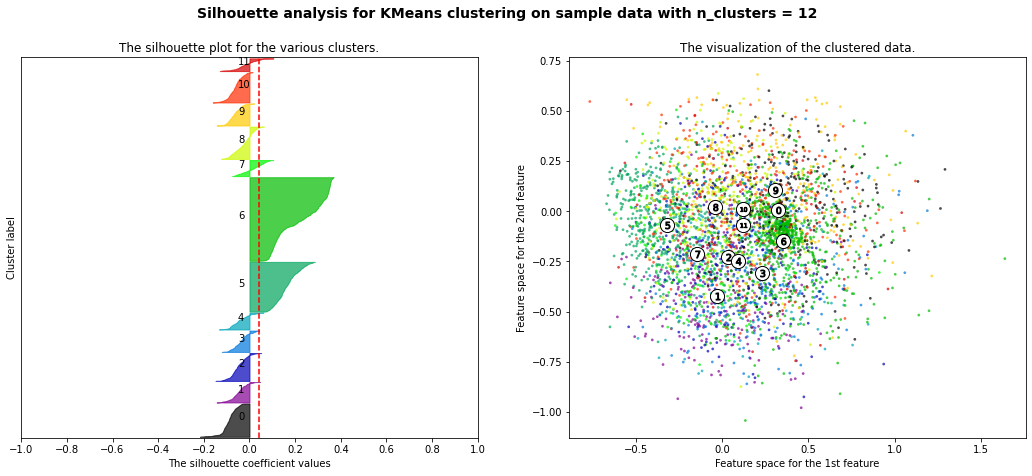

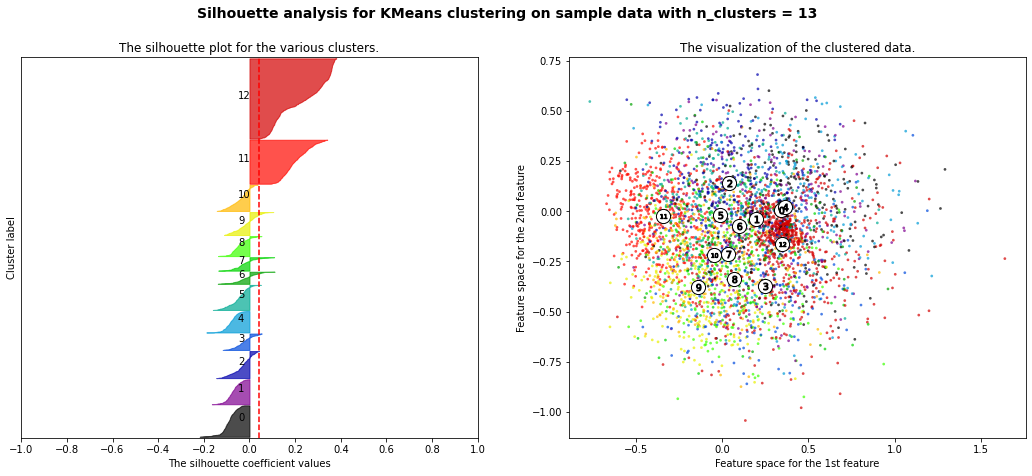

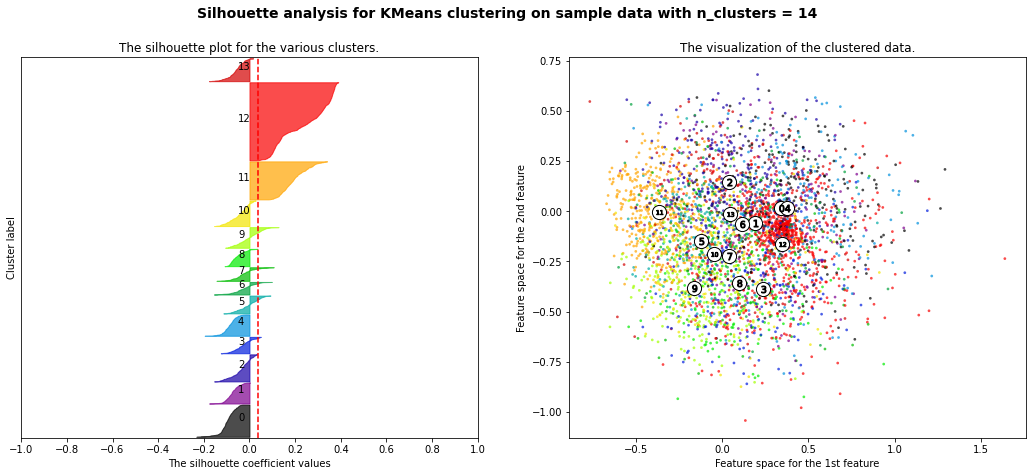

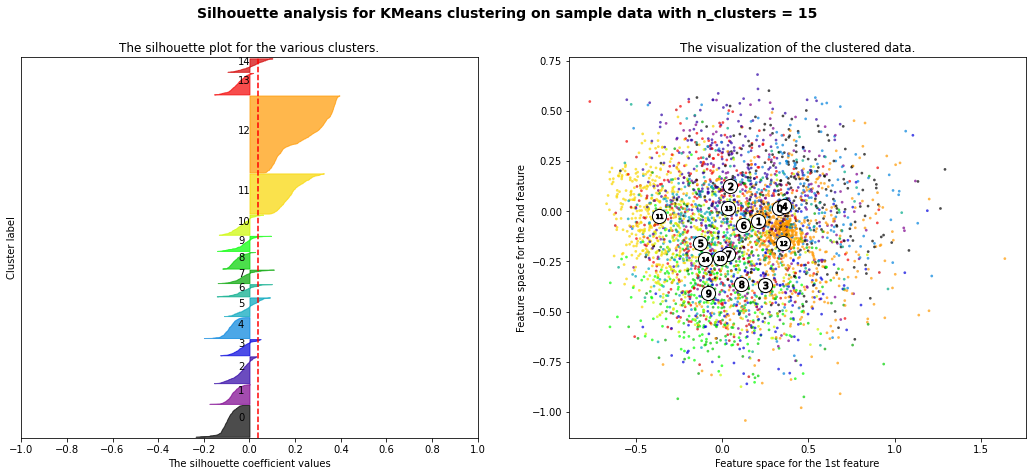

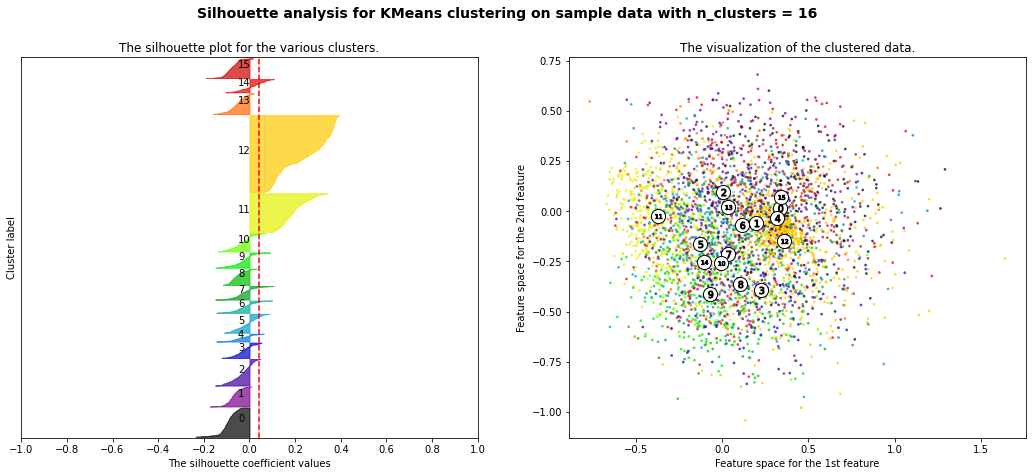

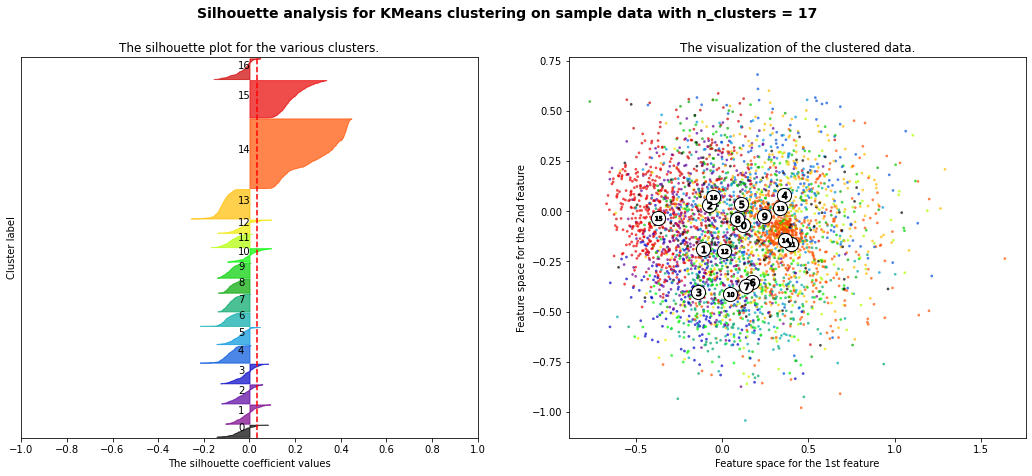

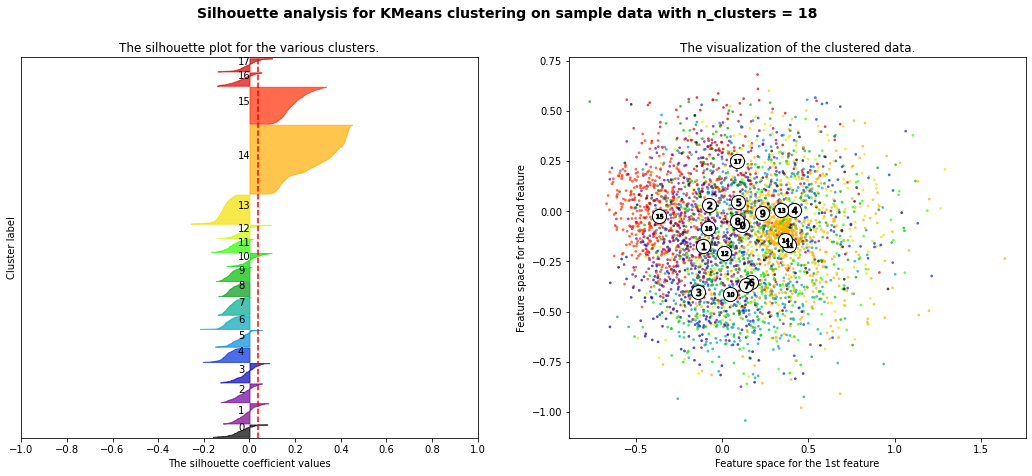

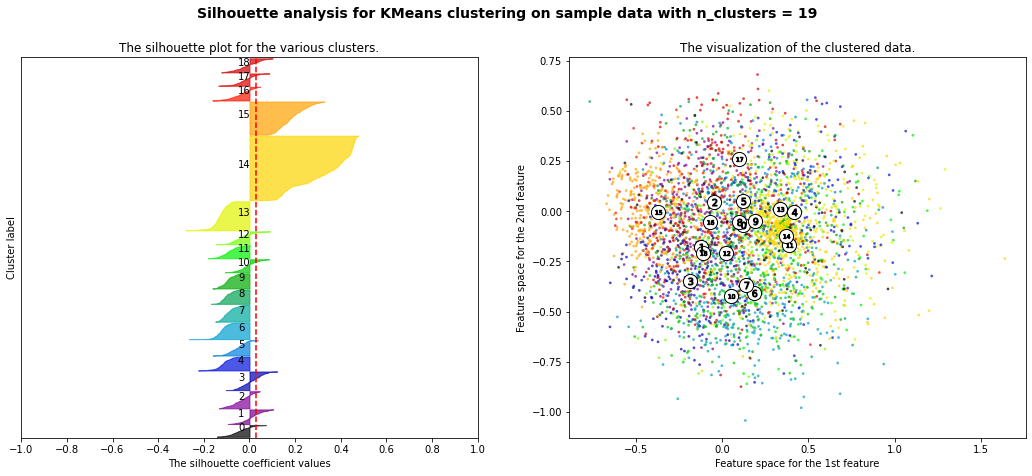

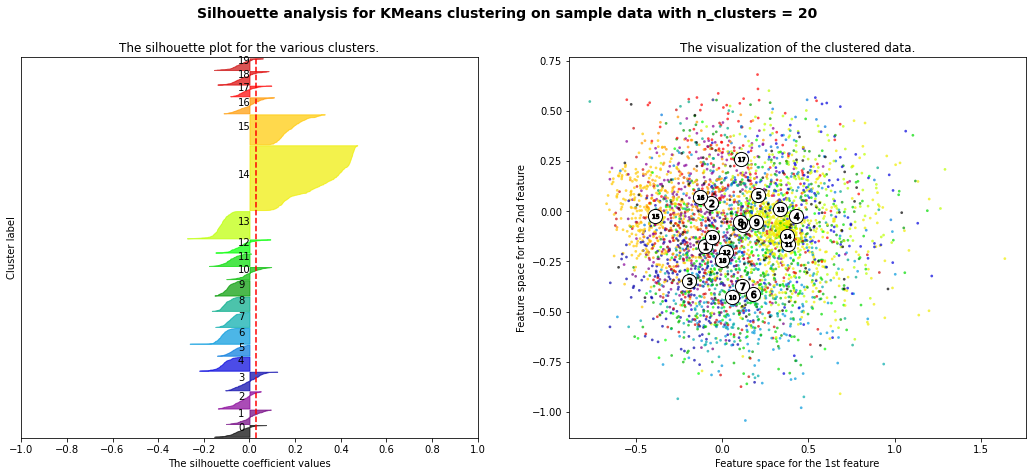

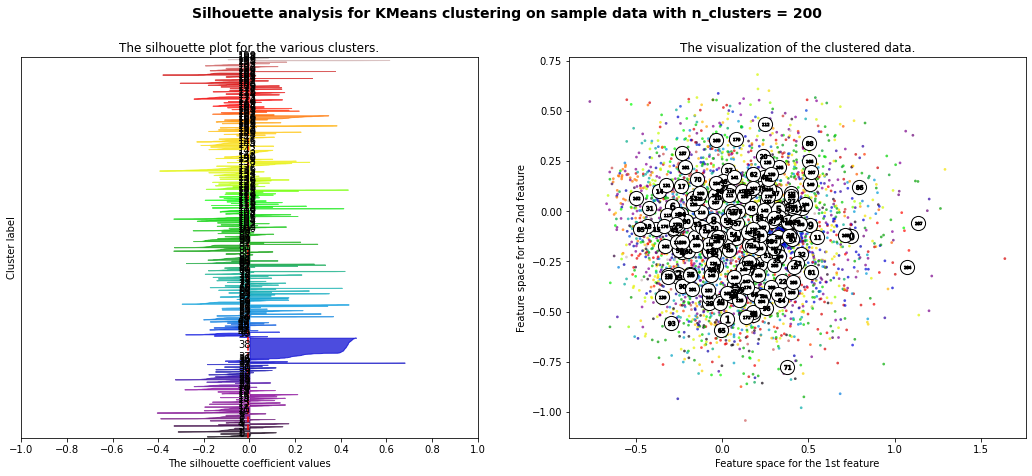

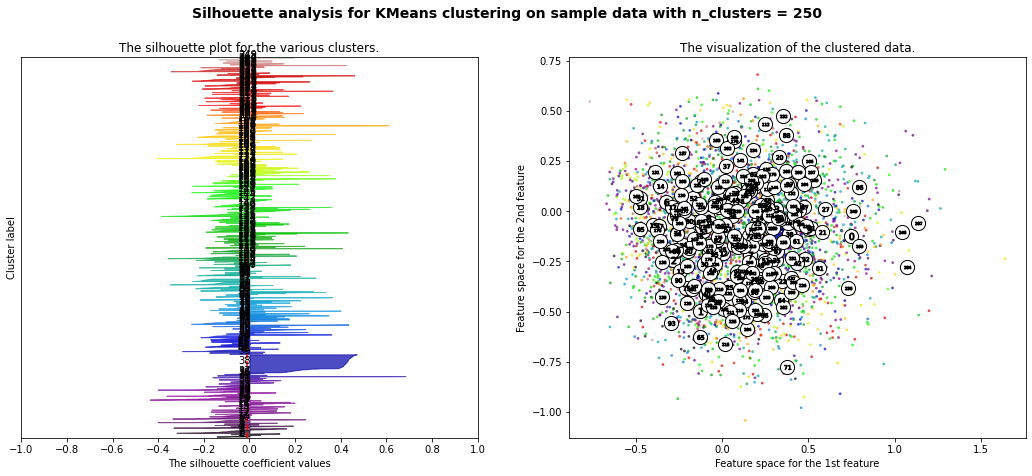

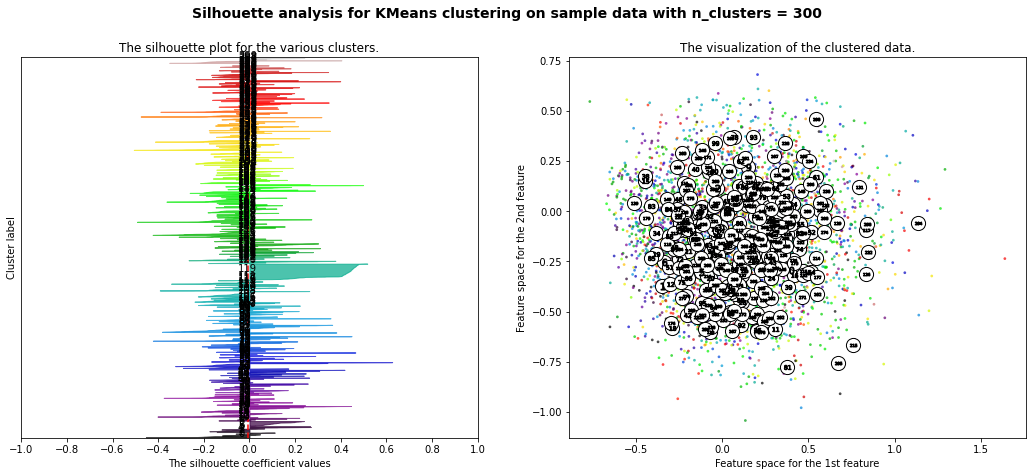

In [ ]:
# For GMF items embeddings -- Results not as good as MLP

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = list(range(2, 21))
b = [200, 250, 300]
range_n_clusters.extend(b)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# DBSCAN siloutte analysis approach

In [ ]:
X = dataset.iloc[:, np.r_[0:64]]
X = np.array(X)
Y = dataset['Label']
Y = np.array(Y)

Automatically created module for IPython interactive environment
Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.001
Completeness: 0.418
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.635


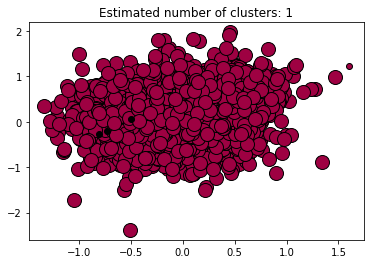

In [ ]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# Compute DBSCAN
db = DBSCAN(eps=7, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(Y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(Y, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(Y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(Y, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Next steps after silhoutte analysis (9 clusters)

**Summary findings of silhoutte analysis:**
- Map each movie into the 9 clusters
- K Means Silhoutte analysis
1. Using kmeans clustering to find ideal number of clusters
2. Not ideal. do not have a good optimal clustering
3. Silhouette score at 0.18 for 2 clusters, 0.14 for 9 or 10 cluster
4. Tried with both mlp and gmf: mlp works better

- DBSCAN silhoutte analysis
1. Similar to k-means, but supposed to deal with high density points
2. Not ideal as well, optimal clustering is 2 clusters, with sihoutte score at 0.58.

**Next steps:**

1. Identify the number of clusters (base on sihoutte analysis) —> 9
2. Find "user path" df of all users who watch a movie of the particular genre with the condition that he/she have not watched the genre in the 10 movies before the particular movie. In addition the movie sequence consist of 10 movies before and as well as 10 movies after the particular movie. 
3. Generate the following variables from the df:
- Cluster of the immediate prior movie 
- Cluster of the target movie
- Linear and non-linear distance between the two movies
- Distance between the particular movie to its nearest centroid.
- Distance between the particular movie to the immediate prior movie's centroid.

Qns to answer:
- Find whether the movie before the target movie is in the same cluster, if not, how far away is the movie?
- Hypothesis - if both movies are in the same cluster, we should see higher correlation of n to d. i.e. the closer the distance, the higher the corelation. if it is not in the same cluster, it should have lower correlation.

## Map the 9 clusters for each point

In [22]:
# Define target variables
X = dataset.iloc[:, np.r_[0:64]]
Y = dataset['Label']
print("input:\n", X)
print("Target:\n", Y)

input:
             0         1         2   ...        61        62        63
0    -0.745756 -0.810328 -0.180637  ... -0.113671  0.664693 -0.306955
1    -0.375606 -0.429183 -0.441106  ... -0.390956  0.233110 -0.741150
2    -0.227230 -0.456836  0.157980  ... -0.067575  0.419661 -0.313982
3    -0.398684 -0.282128  0.012208  ...  0.298142  0.493528  0.016806
4     0.060892 -0.138244 -0.118853  ...  0.263117  0.346135 -0.067497
...        ...       ...       ...  ...       ...       ...       ...
3698  0.694461  0.068542  0.612856  ...  0.123586 -0.029553  0.375214
3699  0.133477  0.202511  0.300273  ...  0.413007 -0.122140  0.524180
3700  0.593592  0.434417  0.365325  ...  0.747357  0.125996  0.633827
3701 -0.421032  0.010697  0.047818  ...  1.041316  0.397842  0.698279
3702  0.108351 -0.047785  0.500352  ...  0.370696  0.058396  0.260548

[3703 rows x 64 columns]
Target:
 0        0
1        1
2        2
3        3
4        4
        ..
3698     4
3699    12
3700    12
3701    12
3702   

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

clusterer = KMeans(n_clusters = 9, random_state=10)
cluster_labels = clusterer.fit_predict(X)
cluster_labels

array([4, 4, 1, ..., 5, 5, 1], dtype=int32)

In [24]:
cluster_labels_df = pd.DataFrame(cluster_labels)
cluster_labels_df = cluster_labels_df.rename(columns = {0: 'cluster_label'})
cluster_labels_df.head(2)

dataset_cluster_label = pd.concat([dataset, cluster_labels_df], axis = 1)
dataset_cluster_label.head(2)


0         1         2  ...  categories_movie_isin  Label  cluster_label
0 -0.745756 -0.810328 -0.180637  ...       3_genre_category      0              4
1 -0.375606 -0.429183 -0.441106  ...       3_genre_category      1              4

[2 rows x 73 columns]

## Find the distance of each point to the nearest centroid (9 clusters)

In [25]:


from sklearn.neighbors import NearestCentroid
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances

closest, min_dist = pairwise_distances_argmin_min(X, clusterer.cluster_centers_)
#clusterer.cluster_centers_
min_dist

array([3.865998 , 2.3727248, 2.5216544, ..., 2.1220617, 2.0562606,
       2.297051 ], dtype=float32)

In [27]:
# Distance of each point to the 9 clusters
X_np = np.array(X)
centroids = clusterer.cluster_centers_
distance = []
for i in X_np:
  data_point = np.array(i).reshape(1,-1)
  distance_to_point = pairwise_distances(data_point, centroids)
  distance.extend(distance_to_point)
  
distance_all_centroids_df = pd.DataFrame(distance)
distance_all_centroids_df.head()

0         1         2  ...          6         7         8
0  5.293090  4.718252  5.416653  ...  14.083305  6.065824  7.028466
1  3.675853  3.924625  4.244413  ...  12.520317  4.715277  5.508956
2  2.716971  2.521654  3.513480  ...  11.495652  4.279936  5.467272
3  2.644187  2.066296  3.452325  ...  11.569564  3.945107  4.916727
4  1.994884  2.565214  3.765560  ...  11.738630  3.795501  4.727033

[5 rows x 9 columns]

## Add the distances (distance to nearest centroid and all centroids) to centroid to the dataset

In [28]:
distance_nearest_centroid = pd.DataFrame(min_dist)
distance_nearest_centroid_df = distance_nearest_centroid.rename(columns = {0: 'distance_centroid'})
distance_nearest_centroid_df.head(2)

distance_centroid
0           3.865998
1           2.372725

In [29]:
dataset_cluster_label = pd.concat([dataset_cluster_label, distance_nearest_centroid_df], axis = 1)
dataset_cluster_label.head(2)


0         1         2  ...  Label  cluster_label  distance_centroid
0 -0.745756 -0.810328 -0.180637  ...      0              4           3.865998
1 -0.375606 -0.429183 -0.441106  ...      1              4           2.372725

[2 rows x 74 columns]

In [30]:
centroids_df = dataset_cluster_label[['item_id', 'movieId', 'title', 'genres', 'cluster_label', 'distance_centroid']]
centroids_df = pd.concat([centroids_df, distance_all_centroids_df], axis = 1)
centroids_df = centroids_df.rename(columns = {0:'cluster_0', 1:'cluster_1', 2:'cluster_2', 3:'cluster_3', 4:'cluster_4', 5:'cluster_5',
                                            6:'cluster_6', 7:'cluster_7', 8:'cluster_8'})
centroids_df.head(2)

item_id  movieId             title  ...  cluster_6  cluster_7  cluster_8
0        0        1  Toy Story (1995)  ...  14.083305   6.065824   7.028466
1        1        2    Jumanji (1995)  ...  12.520317   4.715277   5.508956

[2 rows x 15 columns]

In [31]:
print(len(centroids_df)) # to confirm that total movies remain 3703

3703


# Find the sequence of movies watched by users which fits the criteria ("Embedding path")

In [ ]:
ratings.head(2)

userId  movieId  rating  timestamp  user_id
0       1     1193     5.0  978300760        0
1       1      661     3.0  978302109        0

In [ ]:
movies.head(2)

movie_id             title  ...  year                             genre
0         1  Toy Story (1995)  ...  1995   [Animation, Children's, Comedy]
1         2    Jumanji (1995)  ...  1995  [Adventure, Children's, Fantasy]

[2 rows x 5 columns]

In [32]:
# Add column Genres
ratings_movies = pd.merge(ratings, movies, left_on = 'movieId', right_on = 'movie_id', how = 'left' )
ratings_movies['count'] = 1
ratings_movies = ratings_movies.sort_values(by=['userId','timestamp'])
ratings_movies['movies_order'] = ratings_movies.groupby(by=['userId'])['count'].transform(lambda x: x.cumsum())
ratings_movies['item_id'] = ratings_movies['movieId']
ratings_movies = ratings_movies.drop(['movie_id','count'], axis=1)
ratings_movies.head()


userId  movieId  ...  movies_order  item_id
31       1     3186  ...             1     3186
22       1     1270  ...             2     1270
27       1     1721  ...             3     1721
37       1     1022  ...             4     1022
24       1     2340  ...             5     2340

[5 rows x 11 columns]

## Find user path

In [33]:
type_genre = "Documentary"
#type_genre = 'Sci-Fi'
#type_genre = "Children's"
#type_genre = 'Horror'

all_genres = ratings_movies[['movieId', 'title', 'genres']]
all_genres = all_genres.drop_duplicates()
all_genres['genre'] = all_genres.genres.str.split('|')
sub_df = all_genres[all_genres.genres.str.contains(type_genre)]
print(len(sub_df))
print(sub_df.head(2))

110
     movieId                    title       genres          genre
306     1192  Paris Is Burning (1990)  Documentary  [Documentary]
328      162             Crumb (1994)  Documentary  [Documentary]


In [34]:
from sklearn.metrics.pairwise import manhattan_distances

n_front = 10
n_back = 10

all_users_targetmovies = pd.DataFrame()
selected_movies = list(set(sub_df['movieId']))

for target in selected_movies:

  # chosee only instances where the selected movies has at least 'n_front' movies before them (improve computational effiency)
  filter_movies = ratings_movies[(ratings_movies['movieId'] == target) & (ratings_movies['movies_order'] > n_front) ] # Selected movies 
  movies_name = list(ratings_movies[ratings_movies['movieId'] == target]['title'].drop_duplicates())[0]

  # to ignore blank dataframes
  if len(filter_movies) != 0:
  
    # Check when user watch selected movies
    order_dict = {}
    for i in list(filter_movies.index.values):
      order_dict[filter_movies['userId'][i]] = filter_movies['movies_order'][i]

    seq_df = pd.DataFrame()
    for k in list(order_dict.keys()):
      df_temp = ratings_movies.loc[(ratings_movies['userId'] == k) & ((order_dict[k] - n_front) <= ratings_movies['movies_order']) & ((order_dict[k] + n_back) >= ratings_movies['movies_order'])]
      seq_df = pd.concat([seq_df, df_temp])

    seq_df['count'] = 1
    seq_df['new_movies_order'] = seq_df.groupby(by = ['userId'])['count'].transform(lambda x: x.cumsum())

    genres_seq_first = seq_df.groupby('userId')['genre'].apply(lambda x: x.tolist()) # Get sequence of genres by user
 
    user_path_df = pd.DataFrame()
    for user in list(genres_seq_first.index.values):
      check_previous = 0
      num_movies = 0
      for j in genres_seq_first[user][:n_front]: # check previous movies not in selected genre
        if type_genre not in j:
          check_previous += 1
      if check_previous == n_front: #and num_movies >= n_after: 
        user_path_df = pd.concat([user_path_df, seq_df[seq_df['userId'] == user][['userId','movieId','title','genre','timestamp', 'new_movies_order']]])
  
    # Next steps - using the user_path_df of the target movie, find all users' previous movie cluster and target movie cluster and distance
    
    if len(user_path_df) != 0: 
      all_user_path_df = pd.merge(user_path_df, dataset_cluster_label, how = 'left', on = 'movieId')

      na_users = all_user_path_df[all_user_path_df.isnull().any(axis=1)].userId
      all_users = all_user_path_df.userId.unique()
      filtered_users = set(all_users) - set(na_users)

      stepping_movies = []
      previousmovie_cluster_label_list = []
      targetmovie_cluster_label_list = []
      linear_distance_list = []
      nonlinear_distance_list = []
      num_movies = []
      users_list = []
    

      for user_targetmovie in filtered_users:
        df = all_user_path_df[all_user_path_df['userId'] == user_targetmovie]
        movie_title = df.iloc[n_front: n_front +1,]['title_y'].values.tolist()
        previous_movie_label = df.iloc[n_front -1:n_front,]['cluster_label'].values.tolist()
        target_movie_label = df.iloc[n_front:n_front+1,]['cluster_label'].values.tolist()
        #previous_movie_label = df.iloc[n_front:n_front+1,]['distance_centroid'].values.tolist()
        #target_movie_distance_centroid = df.iloc[n_front:n_front+1,]['distance_centroid'].values.tolist()

        users_list.append(user_targetmovie)
        stepping_movies.extend(movie_title)
        previousmovie_cluster_label_list.extend(previous_movie_label)
        targetmovie_cluster_label_list.extend(target_movie_label)

        # find distance
        target_movie_location = df[df['userId']== user_targetmovie][n_front: n_front + 1][np.r_[0:64]].to_numpy() 
        previous_movie_location = df[df['userId'] == user_targetmovie][n_front-1 : n_front][np.r_[0:64]].to_numpy()
        linear_distance_list.append(np.linalg.norm(target_movie_location - previous_movie_location))
        nonlinear_distance_list.extend(manhattan_distances(target_movie_location, previous_movie_location).ravel())

        genres_seq = df.groupby('userId')['genre'].apply(lambda x: x.tolist()) # Get sequence of genres by user

        count = 0
        for genres_list in genres_seq[user_targetmovie][n_front:]: 
          if type_genre in genres_list:
            count += 1
        num_movies.append(count)

      final_df = pd.DataFrame({'user': users_list, 'target_movie_cluster': targetmovie_cluster_label_list, 'previous_movie_cluster':previousmovie_cluster_label_list,
                             'target_movie_title':stepping_movies, 'linear_distance': linear_distance_list, 'nonlinear_distance': nonlinear_distance_list, 'movies_count': num_movies})
    
      all_users_targetmovies = pd.concat([all_users_targetmovies, final_df])
  

all_users_targetmovies

user  target_movie_cluster  ...  nonlinear_distance movies_count
0   3720                   5.0  ...           44.086722            2
1   2825                   5.0  ...           41.075234            2
2   1291                   5.0  ...           32.407304            1
3   2829                   5.0  ...           32.702410            1
4   1041                   5.0  ...           28.552411            1
..   ...                   ...  ...                 ...          ...
21  5749                   5.0  ...           25.537385            1
22  3128                   5.0  ...           15.998838            1
23   698                   5.0  ...           21.122401            1
0   1147                   3.0  ...           29.238772            2
1   1470                   3.0  ...           34.668440            1

[4324 rows x 7 columns]

## Include distance variables (i.e. to centroids and prior movie) into df

In [35]:
# just a validation check on the above
new_df = all_users_targetmovies.drop_duplicates()
len(new_df)

4324

In [37]:
def centroid_dis(row):
  if row['previous_movie_cluster'] == 0 :
      col_str = 'cluster_' + str(0)
      return row[col_str]
  elif row['previous_movie_cluster'] == 1 :
      col_str = 'cluster_' + str(1)
      return row[col_str]
  elif row['previous_movie_cluster'] == 2 :
      col_str = 'cluster_' + str(2)
      return row[col_str]
  elif row['previous_movie_cluster'] == 3 :
      col_str = 'cluster_' + str(3)
      return row[col_str]
  elif row['previous_movie_cluster'] == 4 :
      col_str = 'cluster_' + str(4)
      return row[col_str]
  elif row['previous_movie_cluster'] == 5 :
      col_str = 'cluster_' + str(5)
      return row[col_str]
  elif row['previous_movie_cluster'] == 6 :
      col_str = 'cluster_' + str(6)
      return row[col_str]
  elif row['previous_movie_cluster'] == 7 :
      col_str = 'cluster_' + str(7)
      return row[col_str]
  elif row['previous_movie_cluster'] == 8 :
      col_str = 'cluster_' + str(8)
      return row[col_str]                          

In [38]:
new_df2 = pd.merge(new_df, centroids_df, how = 'left', left_on = 'target_movie_title', right_on = 'title')
print(len(new_df2))

# use the above condition function to filter out the corresponding movie_cluster
new_df2['distance_lastmovie_centroid'] = new_df2.apply (lambda row: centroid_dis(row), axis=1)

new_df2['user_count'] = 1
analysis = new_df2[['user', 'target_movie_cluster', 'previous_movie_cluster', 'target_movie_title', 'linear_distance', 'nonlinear_distance', 'movies_count', 'user_count',
                   'distance_centroid', 'distance_lastmovie_centroid']]
analysis.head()

4324


user  target_movie_cluster  ...  distance_centroid distance_lastmovie_centroid
0  3720                   5.0  ...           2.440681                    5.042571
1  2825                   5.0  ...           2.440681                    3.595729
2  1291                   5.0  ...           2.440681                    3.595729
3  2829                   5.0  ...           2.440681                    2.440681
4  1041                   5.0  ...           2.440681                    3.713079

[5 rows x 10 columns]

In [39]:
# generate total movies count and users counts of the combined key : "target movie / target movie's cluster / prior movie's cluster"
users_in_genre = analysis.pivot_table(values = ['movies_count','user_count'], index = ['target_movie_title', 'target_movie_cluster', 'previous_movie_cluster'],
               aggfunc = {'movies_count': np.sum, 'user_count' : np.sum}).reset_index()
print(len(users_in_genre))
users_in_genre.head()

437


target_movie_title  ...  user_count
0                   42 Up (1998)  ...          10
1                   42 Up (1998)  ...           9
2                   42 Up (1998)  ...          13
3                   42 Up (1998)  ...           3
4  Across the Sea of Time (1995)  ...           1

[5 rows x 5 columns]

In [40]:
centroids_dis = analysis[['target_movie_cluster', 'previous_movie_cluster', 'target_movie_title', 'distance_centroid', 'distance_lastmovie_centroid']]
centroids_dis = centroids_dis.drop_duplicates()
centroids_dis.head()

target_movie_cluster  ...  distance_lastmovie_centroid
0                    5.0  ...                     5.042571
1                    5.0  ...                     3.595729
3                    5.0  ...                     2.440681
4                    5.0  ...                     3.713079
35                   3.0  ...                     6.206785

[5 rows x 5 columns]

In [41]:
# find correlation between linear distance vs movies counts and non-linear distance vs movie counts of the combined key: "target movie / target movie's cluster / prior movie's cluster"
testing = analysis[['target_movie_cluster', 'previous_movie_cluster', 'target_movie_title', 'linear_distance', 'movies_count', 'nonlinear_distance']]
testing_corr = testing.groupby(['target_movie_cluster', 'previous_movie_cluster', 'target_movie_title']).corr().reset_index()
print(len(testing_corr))
testing_corr = testing_corr[testing_corr['level_3'] == 'movies_count'].drop(['movies_count'], axis = 1)
print(len(testing_corr))
testing_corr.head()

1311
437


target_movie_cluster  ...  nonlinear_distance
1                    0.0  ...            0.419785
4                    0.0  ...            0.254685
7                    0.0  ...            0.070086
10                   0.0  ...           -0.066534
13                   0.0  ...                 NaN

[5 rows x 6 columns]

In [43]:
print(len(users_in_genre), len(centroids_dis), len(testing_corr))

437 437 437


In [44]:
final_analysis1 = pd.merge(users_in_genre, centroids_dis, how = 'left', on = ['target_movie_title', 'target_movie_cluster', 'previous_movie_cluster'])
final_analysis2 = pd.merge(final_analysis1, testing_corr, how = 'left', on = ['target_movie_title', 'target_movie_cluster', 'previous_movie_cluster'])
final_analysis2 = final_analysis2.rename(columns = {'linear_distance': 'corr_linear_distance', 'non-linear_distance': 'corr_nonlinear_distance'})
filter_users = final_analysis2[final_analysis2['user_count'] >= 50] # pvalue
filter_users.head()

target_movie_title  ...  nonlinear_distance
13   American Movie (1999)  ...            0.082950
108           Crumb (1994)  ...            0.073540
110           Crumb (1994)  ...            0.043175
218     Hoop Dreams (1994)  ...           -0.081419
219     Hoop Dreams (1994)  ...           -0.132681

[5 rows x 10 columns]

## Plot the distance of target movie from its centroid against total movies watched

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


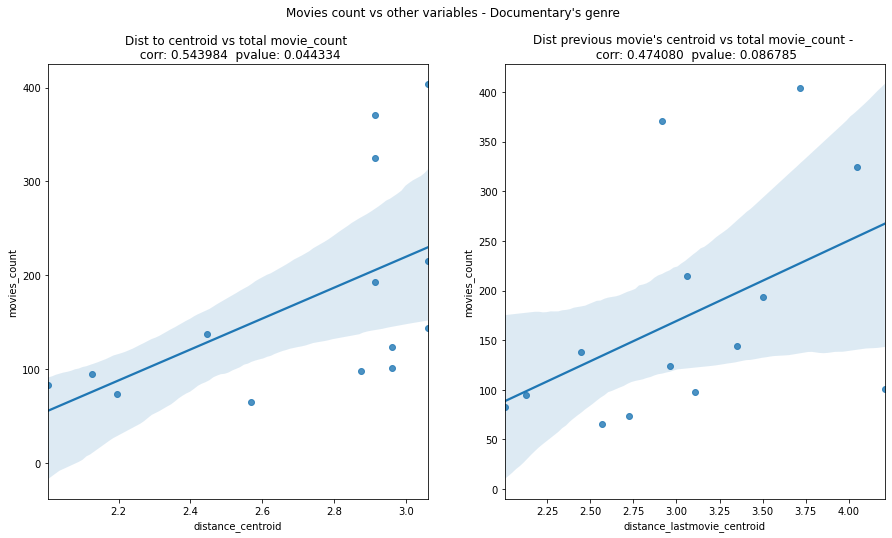

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15,8))

corr_centroid, pvalue_centroid = pearsonr(filter_users['distance_centroid'], filter_users['movies_count'])
corr_priorcentroid__, pvalue_priorcentroid = pearsonr(filter_users['distance_lastmovie_centroid'], filter_users['movies_count'])

p1 = sns.regplot(filter_users['distance_centroid'], filter_users['movies_count'], ax = ax3, order = 1, logx = False)
p2 = sns.regplot(filter_users['distance_lastmovie_centroid'], filter_users['movies_count'], ax = ax4)

plt.suptitle("Movies count vs other variables - Documentary's genre")
ax3.set_title("Dist to centroid vs total movie_count \n corr: %f  pvalue: %f" % (corr_centroid, pvalue_centroid))
ax4.set_title("Dist previous movie's centroid vs total movie_count - \n corr: %f  pvalue: %f" % (corr_priorcentroid__, pvalue_priorcentroid))
plt.show()
fig.savefig('%s.png' %type_genre)

## Tabulate results of correlation of (distance between target and prior movie) against movies watched

In [ ]:
all_users_targetmovies.head()

user  target_movie_cluster  ...  nonlinear_distance movies_count
0  3720                   5.0  ...           44.086722            2
1  2825                   5.0  ...           41.075234            2
2  1291                   5.0  ...           32.407304            1
3  2829                   5.0  ...           32.702410            1
4  1041                   5.0  ...           28.552411            1

[5 rows x 7 columns]

In [ ]:
all_users_targetmovies['user_count'] = 1
table_users = pd.pivot_table(all_users_targetmovies, values = 'user_count', index = 'target_movie_cluster', 
                             columns = 'previous_movie_cluster', aggfunc = np.sum)
table_users

previous_movie_cluster    0.0     1.0     2.0   3.0     4.0    5.0    7.0   8.0
target_movie_cluster                                                           
0.0                     931.0  1240.0   360.0   8.0  1355.0  234.0  149.0  33.0
1.0                     172.0  2163.0   374.0  10.0   829.0  181.0   34.0   3.0
2.0                      29.0   131.0   162.0   1.0   113.0   23.0    7.0  11.0
3.0                       1.0     1.0     NaN   NaN     NaN    NaN    NaN   NaN
4.0                     702.0  2958.0  2411.0  17.0  5507.0  322.0  373.0  39.0
5.0                       8.0    11.0    10.0   NaN     3.0    5.0    6.0   NaN
7.0                       1.0    14.0     9.0   NaN    80.0    3.0   50.0   NaN
8.0                       1.0     1.0     7.0   NaN     2.0    1.0    1.0   1.0

In [ ]:
from scipy.stats import pearsonr
target_movies_list = all_users_targetmovies.target_movie_cluster.values.tolist()
target_movies_list = set(target_movies_list)
target_movies_list

previous_movies_list = all_users_targetmovies.previous_movie_cluster.values.tolist()
previous_movies_list = set(previous_movies_list)

target = []
prior = []
lin_correlation = []
nonlin_correlation = []
for i in target_movies_list:
  for j in previous_movies_list:
    df = all_users_targetmovies[(all_users_targetmovies['target_movie_cluster'] == i) & (all_users_targetmovies['previous_movie_cluster'] == j)]
    linear_d = df.linear_distance.values.tolist()
    non_linear_d = df.nonlinear_distance.values.tolist()
    num_movies = df.movies_count.values.tolist()
    if len(linear_d) <= 1:
      lin_correlation.append(0)
      nonlin_correlation.append(0)
    else:
      linear_d_corr, __ = pearsonr(linear_d, num_movies)
      nonlinear_d_corr, __ = pearsonr(non_linear_d, num_movies)
      lin_correlation.append(linear_d_corr)
      nonlin_correlation.append(nonlinear_d_corr)

    target.append(i)
    prior.append(j)
    
test = pd.DataFrame({'target': target, 'prior': prior, 'lin_corr': lin_correlation, 'nonlin_corr': nonlin_correlation})
test

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target  prior  lin_corr  nonlin_corr
0      0.0    0.0  0.065041     0.076708
1      0.0    1.0  0.078407     0.086062
2      0.0    2.0 -0.020997    -0.030315
3      0.0    3.0  0.263047     0.315367
4      0.0    4.0  0.054938     0.051948
..     ...    ...       ...          ...
59     8.0    3.0  0.000000     0.000000
60     8.0    4.0  1.000000     1.000000
61     8.0    5.0  0.000000     0.000000
62     8.0    7.0  0.000000     0.000000
63     8.0    8.0  0.000000     0.000000

[64 rows x 4 columns]

In [ ]:
table_linear_corr = pd.pivot_table(test, values = 'lin_corr', index = 'target', columns = 'prior')
table_linear_corr

prior        0.0       1.0       2.0  ...       5.0       7.0       8.0
target                                ...                              
0.0     0.065041  0.078407 -0.020997  ... -0.005459  0.195785 -0.121553
1.0    -0.016374  0.055571 -0.009028  ... -0.035680  0.073561       NaN
2.0    -0.075865  0.107416 -0.037992  ... -0.096335 -0.281848 -0.032115
3.0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
4.0     0.220328  0.095005 -0.090965  ...  0.109125  0.210323 -0.192827
5.0    -0.063390  0.485500 -0.007074  ...  0.491138  0.525079  0.000000
7.0     0.000000 -0.273151  0.492073  ...  0.993790  0.348682  0.000000
8.0     0.000000  0.000000  0.374331  ...  0.000000  0.000000  0.000000

[8 rows x 8 columns]

In [ ]:
table_nonlinear_corr = pd.pivot_table(test, values = 'nonlin_corr', index = 'target', columns = 'prior')
table_nonlinear_corr


prior        0.0       1.0       2.0  ...       5.0       7.0       8.0
target                                ...                              
0.0     0.076708  0.086062 -0.030315  ... -0.030947  0.181894 -0.098575
1.0    -0.015908  0.060428 -0.000350  ... -0.062950  0.041485       NaN
2.0    -0.076090  0.133465 -0.020490  ... -0.085800 -0.249962 -0.040092
3.0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
4.0     0.209511  0.089359 -0.085337  ...  0.091061  0.180312 -0.165872
5.0    -0.135102  0.445236 -0.019874  ...  0.513631  0.507307  0.000000
7.0     0.000000 -0.284315  0.596077  ...  0.987533  0.329474  0.000000
8.0     0.000000  0.000000  0.367607  ...  0.000000  0.000000  0.000000

[8 rows x 8 columns]

# Find top 3 genres of each cluster

In [ ]:
df = dataset_cluster_label[['item_id', 'movieId', 'genres', 'cluster_label']]
df['genre'] = df.genres.str.split('|')
df1 = df.explode('genre')
df1.head()

df1['count'] = 1
df_agg = df1.groupby(by = ['cluster_label', 'genre']).sum()
g = df_agg['count'].groupby(level=0, group_keys=False)
final_analysis = g.nlargest(3)
final_analysis

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


cluster_label  genre      
0              Comedy         296
               Action         167
               Children's     141
1              Drama          345
               Comedy         199
               Romance        137
2              Drama          245
               Comedy         133
               Thriller        65
3              Drama          178
               Comedy          94
               Documentary     31
4              Action         217
               Comedy         164
               Sci-Fi         140
5              Drama          488
               Comedy         201
               Romance        134
6              Drama           10
               Comedy           5
               Documentary      5
7              Horror         239
               Sci-Fi          63
               Thriller        61
8              Drama           60
               Comedy          42
               Romance         18
Name: count, dtype: int64

# Correlation plot
**- Loop for all genres, all users**

In [ ]:
x = all_genres.genre.values.tolist()
y = []
for i in x:
  for k in i:
    y.append(k)
unique_genres = list(set(y))
unique_genres

['Fantasy',
 'Adventure',
 'Action',
 'Crime',
 'Western',
 'Film-Noir',
 'Documentary',
 'Drama',
 'Animation',
 'Romance',
 'Horror',
 'Mystery',
 'Musical',
 'Sci-Fi',
 'Comedy',
 'War',
 'Thriller',
 "Children's"]

In [ ]:
for type_genre in unique_genres:
  print(type_genre)

Fantasy
Adventure
Action
Crime
Western
Film-Noir
Documentary
Drama
Animation
Romance
Horror
Mystery
Musical
Sci-Fi
Comedy
War
Thriller
Children's


genre:  Fantasy ,    number of movies with selected genre:  68
all users:  15559  validation check on no duplicates:  15559
final df with number of datapoints:  69


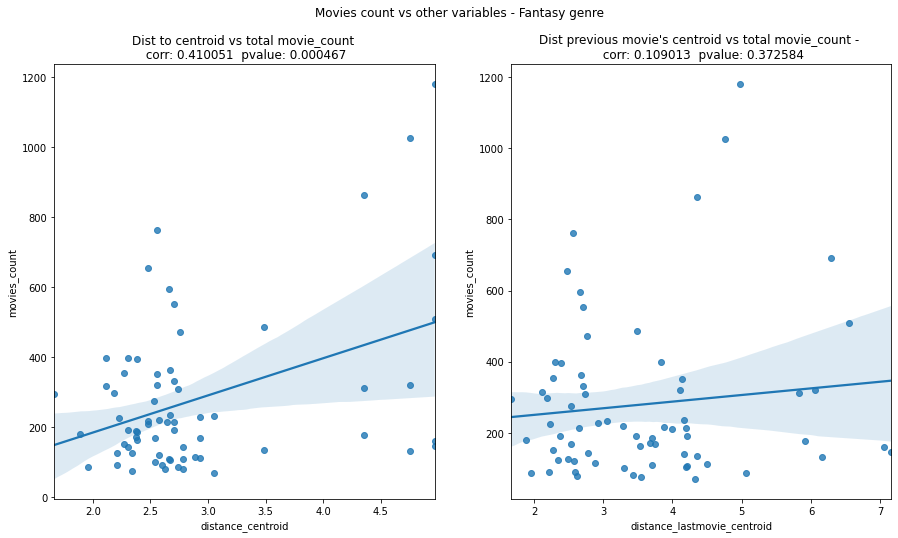

genre:  Adventure ,    number of movies with selected genre:  281
all users:  23757  validation check on no duplicates:  23757
final df with number of datapoints:  108


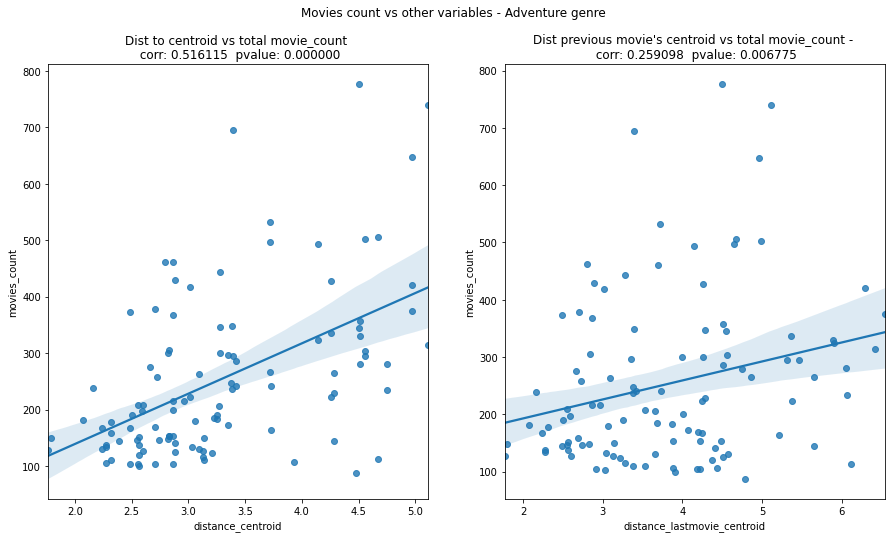

genre:  Action ,    number of movies with selected genre:  495
all users:  20239  validation check on no duplicates:  20239
final df with number of datapoints:  81


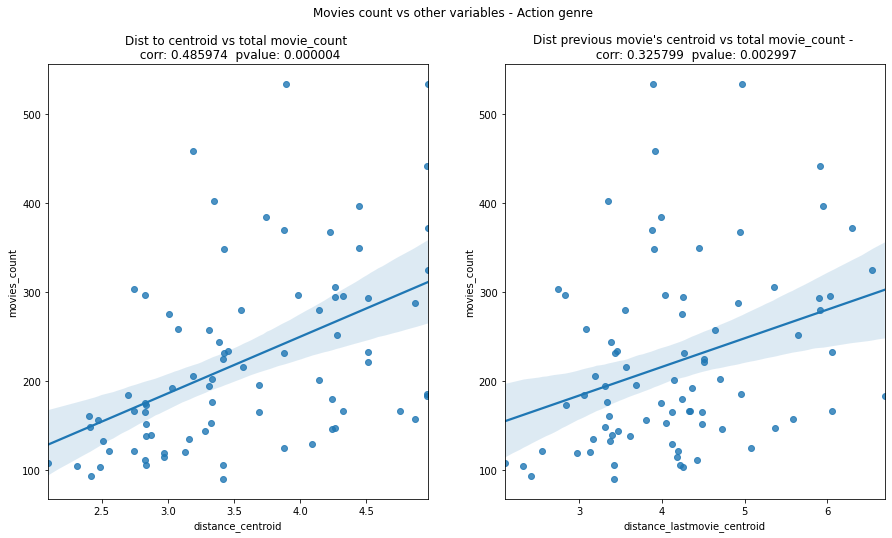

genre:  Crime ,    number of movies with selected genre:  201
all users:  26356  validation check on no duplicates:  26356
final df with number of datapoints:  150


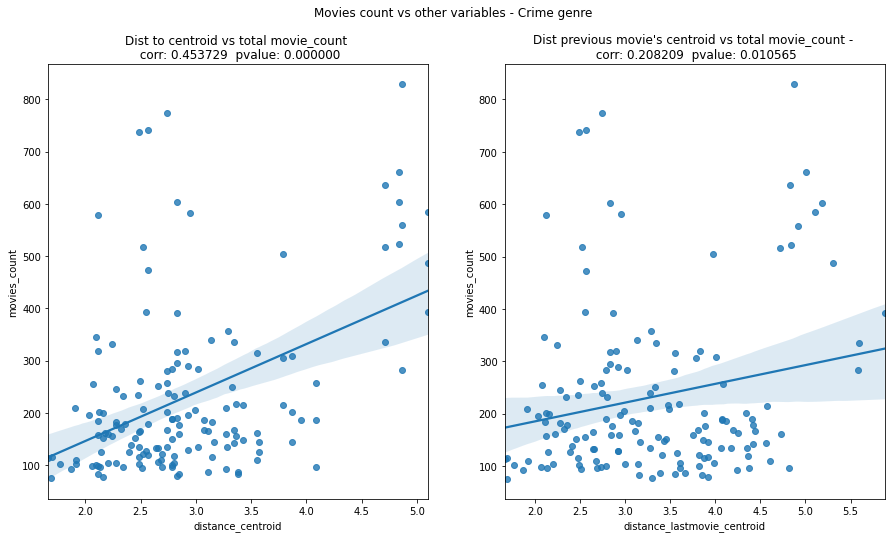

genre:  Western ,    number of movies with selected genre:  67
all users:  11784  validation check on no duplicates:  11784
final df with number of datapoints:  49


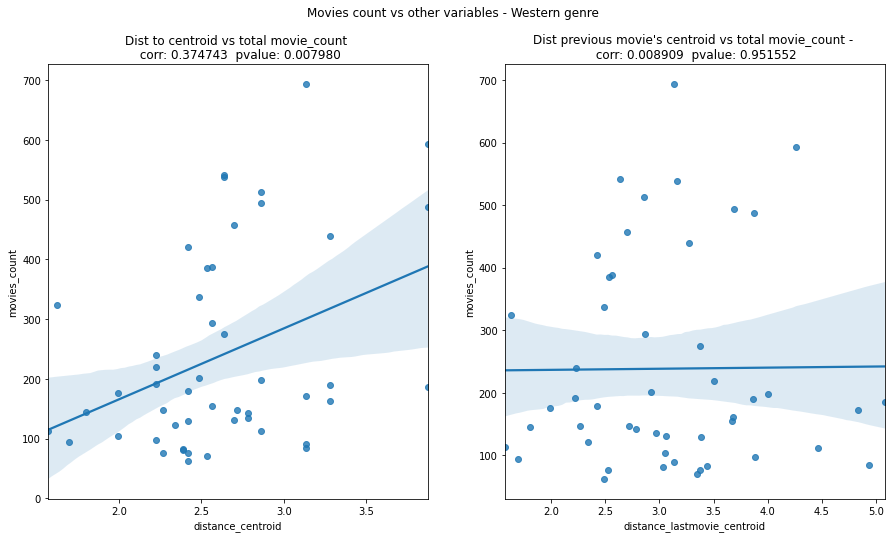

genre:  Film-Noir ,    number of movies with selected genre:  44
all users:  9146  validation check on no duplicates:  9146
final df with number of datapoints:  40


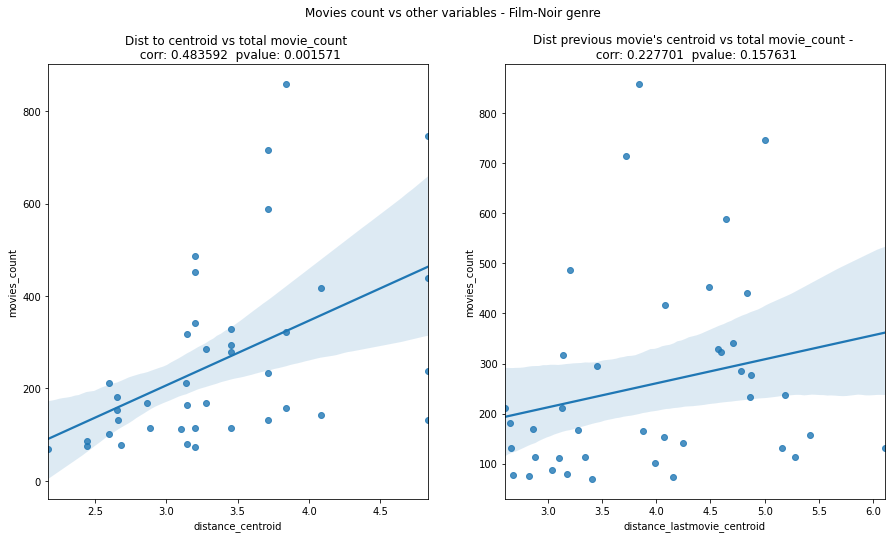

genre:  Documentary ,    number of movies with selected genre:  110
all users:  4324  validation check on no duplicates:  4324
final df with number of datapoints:  14


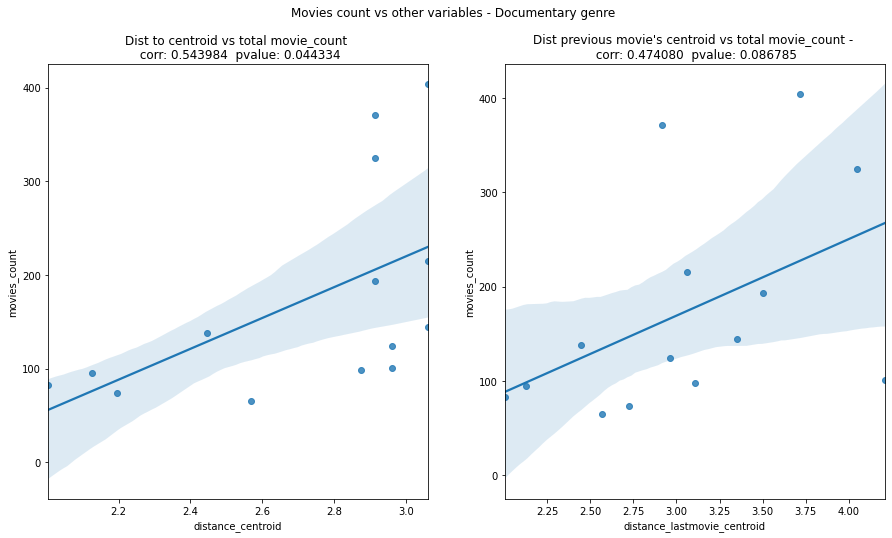

genre:  Drama ,    number of movies with selected genre:  1493
all users:  12414  validation check on no duplicates:  12414
final df with number of datapoints:  29


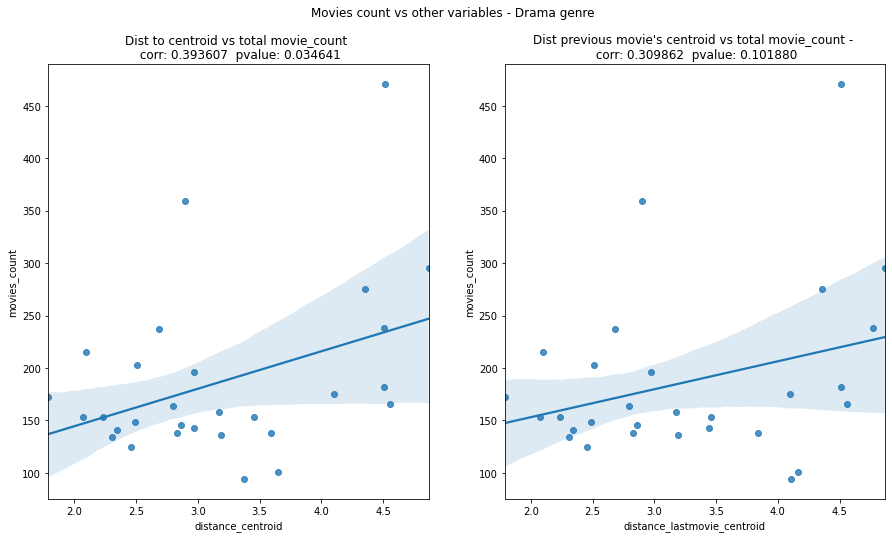

genre:  Animation ,    number of movies with selected genre:  105
all users:  15439  validation check on no duplicates:  15439
final df with number of datapoints:  77


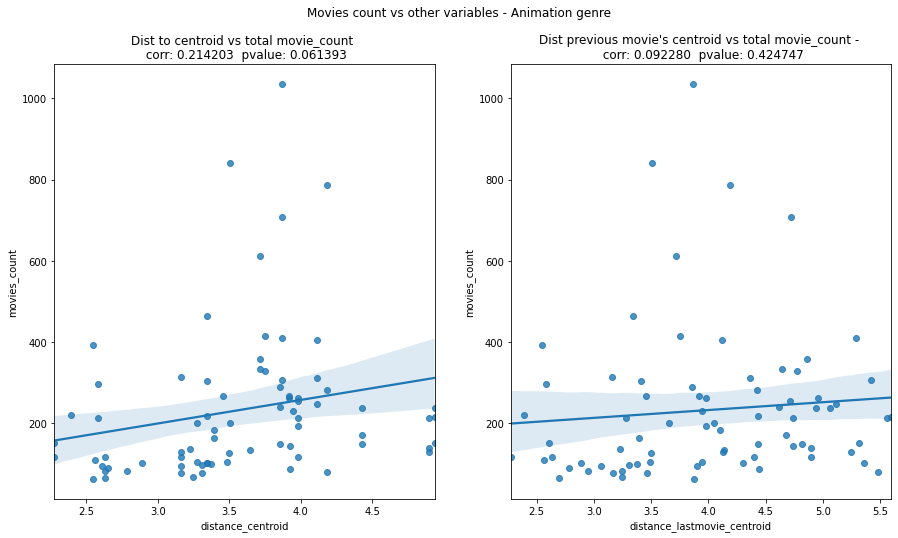

genre:  Romance ,    number of movies with selected genre:  459
all users:  27235  validation check on no duplicates:  27235
final df with number of datapoints:  123


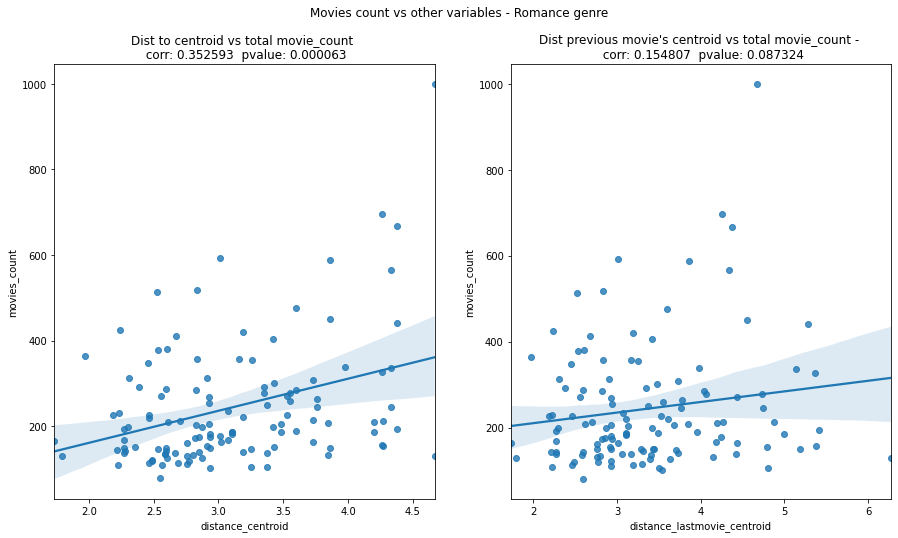

genre:  Horror ,    number of movies with selected genre:  339
all users:  22089  validation check on no duplicates:  22089
final df with number of datapoints:  101


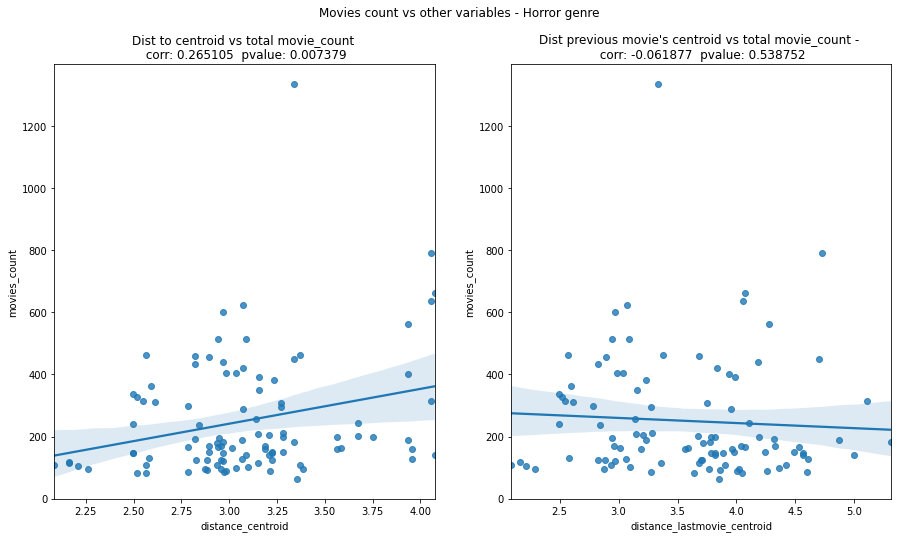

genre:  Mystery ,    number of movies with selected genre:  104
all users:  19463  validation check on no duplicates:  19463
final df with number of datapoints:  102


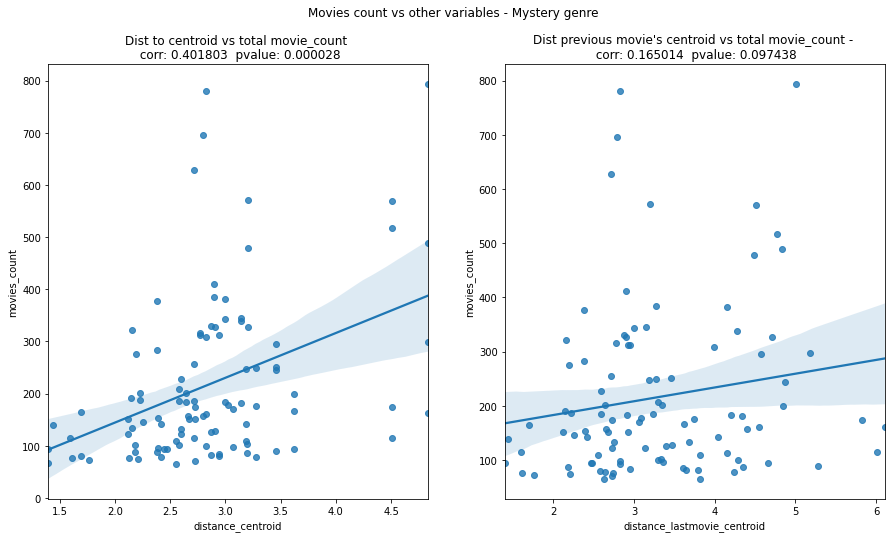

genre:  Musical ,    number of movies with selected genre:  113
all users:  16884  validation check on no duplicates:  16884
final df with number of datapoints:  87


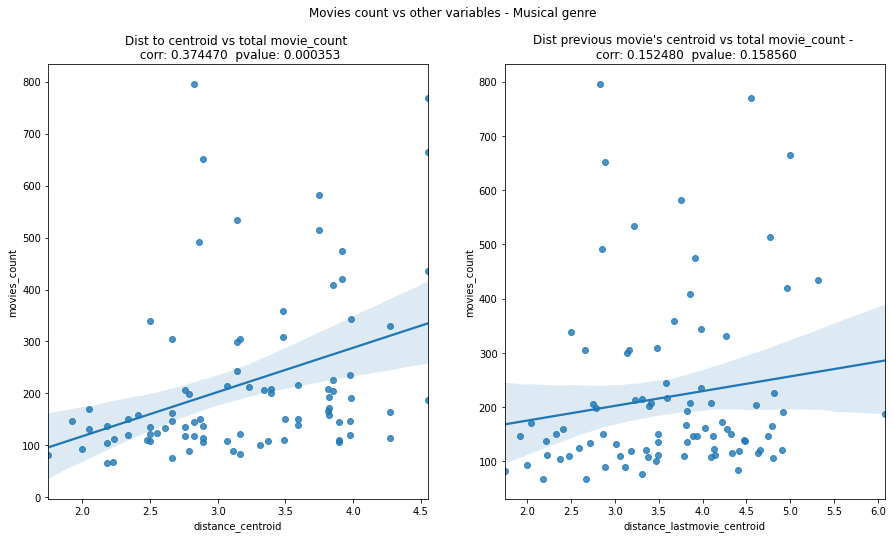

genre:  Sci-Fi ,    number of movies with selected genre:  274
all users:  23250  validation check on no duplicates:  23250
final df with number of datapoints:  126


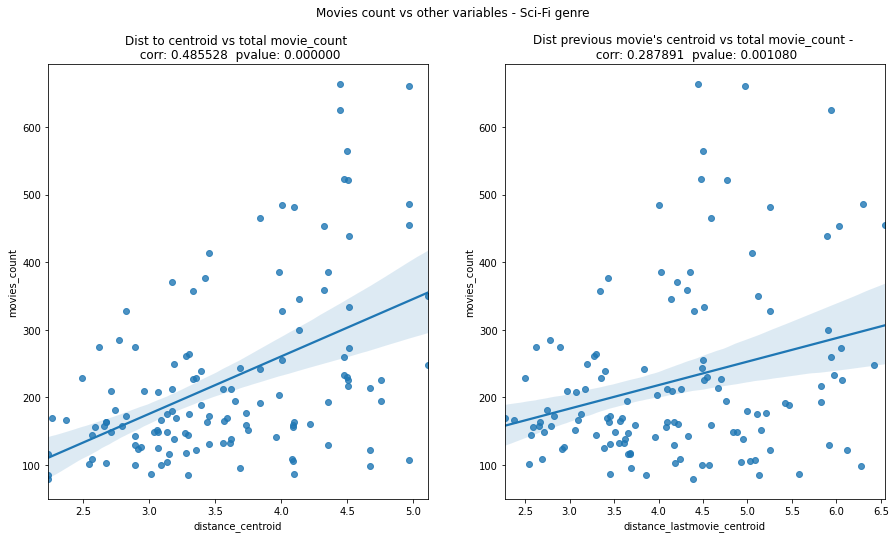

genre:  Comedy ,    number of movies with selected genre:  1163
all users:  14093  validation check on no duplicates:  14093
final df with number of datapoints:  37


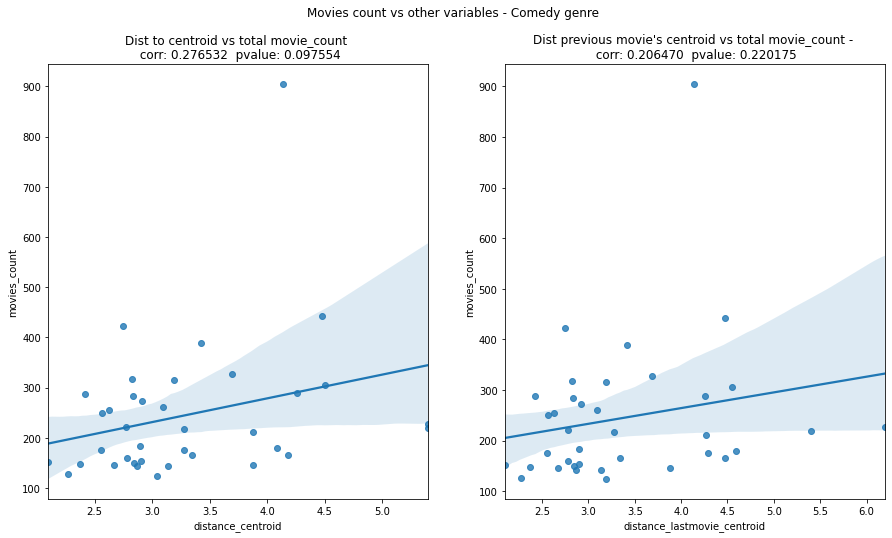

genre:  War ,    number of movies with selected genre:  141
all users:  23519  validation check on no duplicates:  23519
final df with number of datapoints:  125


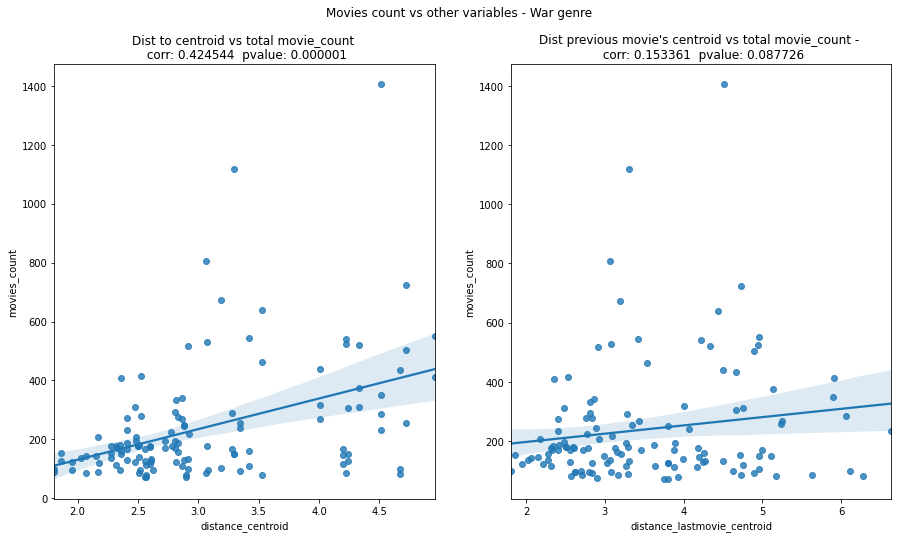

genre:  Thriller ,    number of movies with selected genre:  485
all users:  20696  validation check on no duplicates:  20696
final df with number of datapoints:  89


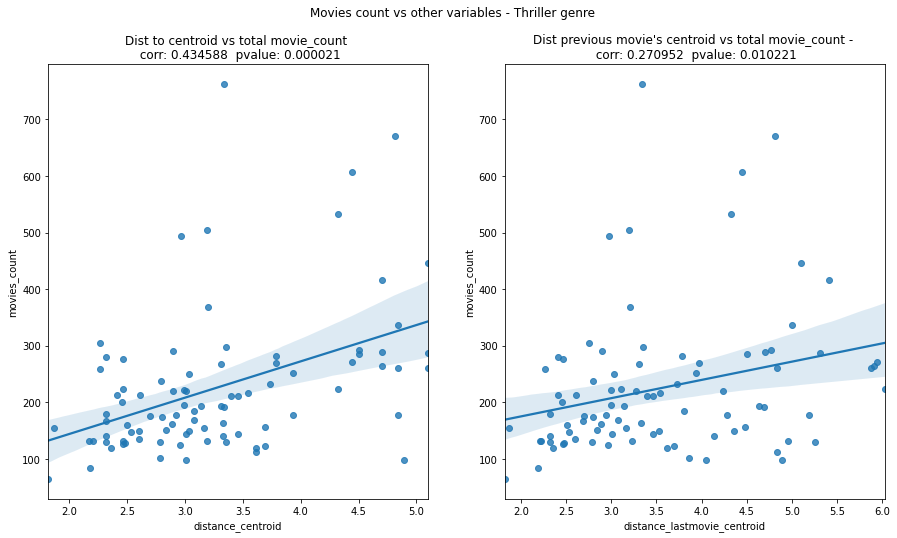

genre:  Children's ,    number of movies with selected genre:  250
all users:  20377  validation check on no duplicates:  20377
final df with number of datapoints:  82


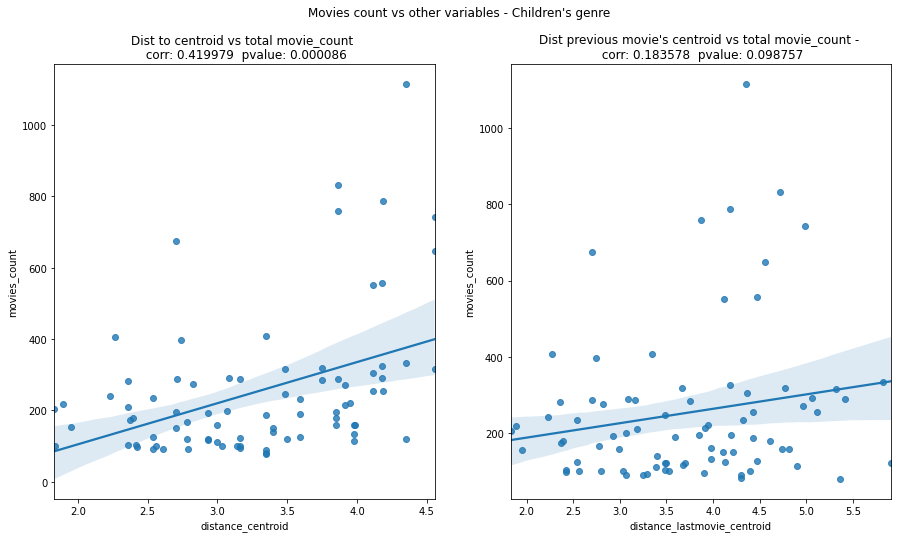

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import manhattan_distances

n_front = 10
n_back = 10

all_genres = ratings_movies[['movieId', 'title', 'genres']]
all_genres = all_genres.drop_duplicates()
all_genres['genre'] = all_genres.genres.str.split('|')

for type_genre in unique_genres:

  sub_df = all_genres[all_genres.genres.str.contains(type_genre)]

  all_users_targetmovies = pd.DataFrame()
  selected_movies = list(set(sub_df['movieId']))
  print('genre: ', type_genre, ',    number of movies with selected genre: ', len(selected_movies))

  all_users_targetmovies = pd.DataFrame()

  for target in selected_movies:

    # chosee only instances where the selected movies has at least 'n_front' movies before them (improve computational effiency)
    filter_movies = ratings_movies[(ratings_movies['movieId'] == target) & (ratings_movies['movies_order'] > n_front) ] # Selected movies 
    movies_name = list(ratings_movies[ratings_movies['movieId'] == target]['title'].drop_duplicates())[0]

    # to ignore blank dataframes
    if len(filter_movies) != 0:
  
      # Check when user watch selected movies
      order_dict = {}
      for i in list(filter_movies.index.values):
        order_dict[filter_movies['userId'][i]] = filter_movies['movies_order'][i]

      seq_df = pd.DataFrame()
      for k in list(order_dict.keys()):
        df_temp = ratings_movies.loc[(ratings_movies['userId'] == k) & ((order_dict[k] - n_front) <= ratings_movies['movies_order']) & ((order_dict[k] + n_back) >= ratings_movies['movies_order'])]
        seq_df = pd.concat([seq_df, df_temp])

      seq_df['count'] = 1
      seq_df['new_movies_order'] = seq_df.groupby(by = ['userId'])['count'].transform(lambda x: x.cumsum())

      genres_seq_first = seq_df.groupby('userId')['genre'].apply(lambda x: x.tolist()) # Get sequence of genres by user
 
      user_path_df = pd.DataFrame()
      for user in list(genres_seq_first.index.values):
        check_previous = 0
        num_movies = 0
        for j in genres_seq_first[user][:n_front]: # check previous movies not in selected genre
          if type_genre not in j:
            check_previous += 1
        if check_previous == n_front: #and num_movies >= n_after: 
          user_path_df = pd.concat([user_path_df, seq_df[seq_df['userId'] == user][['userId','movieId','title','genre','timestamp', 'new_movies_order']]])
  
      # Next steps - using the user_path_df of the target movie, find all users' previous movie cluster and target movie cluster and distance
    
      if len(user_path_df) != 0: 
        all_user_path_df = pd.merge(user_path_df, dataset_cluster_label, how = 'left', on = 'movieId')

        na_users = all_user_path_df[all_user_path_df.isnull().any(axis=1)].userId
        all_users = all_user_path_df.userId.unique()
        filtered_users = set(all_users) - set(na_users)

        stepping_movies = []
        previousmovie_cluster_label_list = []
        targetmovie_cluster_label_list = []
        linear_distance_list = []
        nonlinear_distance_list = []
        num_movies = []
        users_list = []
    

        for user_targetmovie in filtered_users:
          df = all_user_path_df[all_user_path_df['userId'] == user_targetmovie]
          movie_title = df.iloc[n_front: n_front +1,]['title_y'].values.tolist()
          previous_movie_label = df.iloc[n_front -1:n_front,]['cluster_label'].values.tolist()
          target_movie_label = df.iloc[n_front:n_front+1,]['cluster_label'].values.tolist()
          #previous_movie_label = df.iloc[n_front:n_front+1,]['distance_centroid'].values.tolist()
          #target_movie_distance_centroid = df.iloc[n_front:n_front+1,]['distance_centroid'].values.tolist()

          users_list.append(user_targetmovie)
          stepping_movies.extend(movie_title)
          previousmovie_cluster_label_list.extend(previous_movie_label)
          targetmovie_cluster_label_list.extend(target_movie_label)

          # find distance
          target_movie_location = df[df['userId']== user_targetmovie][n_front: n_front + 1][np.r_[0:64]].to_numpy() 
          previous_movie_location = df[df['userId'] == user_targetmovie][n_front-1 : n_front][np.r_[0:64]].to_numpy()
          linear_distance_list.append(np.linalg.norm(target_movie_location - previous_movie_location))
          nonlinear_distance_list.extend(manhattan_distances(target_movie_location, previous_movie_location).ravel())

          genres_seq = df.groupby('userId')['genre'].apply(lambda x: x.tolist()) # Get sequence of genres by user

          count = 0
          for genres_list in genres_seq[user_targetmovie][n_front:]: 
            if type_genre in genres_list:
              count += 1
          num_movies.append(count)

        final_df = pd.DataFrame({'user': users_list, 'target_movie_cluster': targetmovie_cluster_label_list, 'previous_movie_cluster':previousmovie_cluster_label_list,
                                 'target_movie_title':stepping_movies, 'linear_distance': linear_distance_list, 'nonlinear_distance': nonlinear_distance_list, 'movies_count': num_movies})
    
        all_users_targetmovies = pd.concat([all_users_targetmovies, final_df])

  new_df = all_users_targetmovies.drop_duplicates()

  print('all users: ', len(all_users_targetmovies), ' validation check on no duplicates: ', len(new_df))

  new_df2 = pd.merge(new_df, centroids_df, how = 'left', left_on = 'target_movie_title', right_on = 'title')

  # use the above condition to filter out the corresponding movie_cluster
  new_df2['distance_lastmovie_centroid'] = new_df2.apply (lambda row: centroid_dis(row), axis=1)
  new_df2['user_count'] = 1
  analysis = new_df2[['user', 'target_movie_cluster', 'previous_movie_cluster', 'target_movie_title', 'linear_distance', 'nonlinear_distance', 'movies_count', 'user_count',
                            'distance_centroid', 'distance_lastmovie_centroid']]
  users_in_genre = analysis.pivot_table(values = ['movies_count','user_count'], index = ['target_movie_title', 'target_movie_cluster', 'previous_movie_cluster'],
                                              aggfunc = {'movies_count': np.sum, 'user_count' : np.sum}).reset_index()
        
  centroids_dis = analysis[['target_movie_cluster', 'previous_movie_cluster', 'target_movie_title', 'distance_centroid', 'distance_lastmovie_centroid']]
  centroids_dis = centroids_dis.drop_duplicates()

  testing = analysis[['target_movie_cluster', 'previous_movie_cluster', 'target_movie_title', 'linear_distance', 'movies_count', 'nonlinear_distance']]
  testing_corr = testing.groupby(['target_movie_cluster', 'previous_movie_cluster', 'target_movie_title']).corr().reset_index()
  testing_corr = testing_corr[testing_corr['level_3'] == 'movies_count'].drop(['movies_count'], axis = 1)

  final_analysis1 = pd.merge(testing_corr, users_in_genre, how = 'left', on = ['target_movie_title', 'target_movie_cluster', 'previous_movie_cluster'])
  final_analysis2 = pd.merge(final_analysis1, centroids_dis, how = 'left', on = ['target_movie_title', 'target_movie_cluster', 'previous_movie_cluster'])
  filter_users = final_analysis2[final_analysis2['user_count'] >= 50] # pvalue
  print('final df with number of datapoints: ', len(filter_users))

  if len(filter_users) >= 2:
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15,8))

    corr_centroid, pvalue_centroid = pearsonr(filter_users['distance_centroid'], filter_users['movies_count'])
    corr_priorcentroid__, pvalue_priorcentroid = pearsonr(filter_users['distance_lastmovie_centroid'], filter_users['movies_count'])

    sns.regplot(filter_users['distance_centroid'], filter_users['movies_count'], ax = ax3, order = 1, logx = False)
    sns.regplot(filter_users['distance_lastmovie_centroid'], filter_users['movies_count'], ax = ax4)

    plt.suptitle("Movies count vs other variables - %s genre" %type_genre)
    ax3.set_title("Dist to centroid vs total movie_count \n corr: %f  pvalue: %f" % (corr_centroid, pvalue_centroid))
    ax4.set_title("Dist previous movie's centroid vs total movie_count - \n corr: %f  pvalue: %f" % (corr_priorcentroid__, pvalue_priorcentroid))
    plt.show()
    fig.savefig('%s.png' %type_genre)
        
  else:
    print('%s has less than 2 datapoints' %type_genre, '\n')